# Imports

In [26]:
# Cell 2 — Imports
import pandas as pd
from calendar import monthrange
from pulp import (
    LpProblem, LpMinimize, LpVariable, LpStatus, lpSum, value
)

# Config 

In [35]:
# Cell 4 — Config / Inputs (edit these)

from __future__ import annotations

import copy
import hashlib
import json
from calendar import monthrange

# Months (1..12). You can change this to any list of months you model.
months = list(range(1, 13))

# Target power (MW) required EACH month (can be constant or month-by-month)
T_MW = {m: 30 for m in months}

# Choose a year for hours-per-month conversion (leap-year matters for Feb)
year_for_hours = 2026

# =========================
# Run / Plot configuration
# =========================
# Solve mode:
# - If RUN_ALL_SCENARIOS=True: solves ALL scenarios in `scenarios`
# - Else: solves ONLY RUN_SCENARIO_NAME
RUN_ALL_SCENARIOS = True
RUN_SCENARIO_NAME = "Baseline"

# Which scenario should Cells 7 / 9 / 11 plot?
# - Default (None): the first scenario that was solved
# - Set to a scenario name to override, e.g. "Selling_Excess_Power"
PLOT_SCENARIO_NAME = None


############################
# Tiered supply definitions
############################
# Define each SUPPLY (e.g. "solar") once.
# - available_mw: total capacity available (MW) per month
# - tiers: ordered list of price tiers with cumulative breakpoints (MW)
# - use: min/max utilization multipliers in [0,1] applied to TOTAL supply capacity
#   - min: minimum generation as a fraction of nominal capacity ("must-run" if > 0)
#   - max: maximum generation as a fraction of nominal capacity (derating if < 1)
# - payment: per-tier payment mode
#   - "take_or_pay": pay for GENERATED energy in that tier (even if spilled/unused)
#   - "take_and_pay": pay only for DELIVERED energy from that tier (used + sold)
# - sell_unused: optional resale of UNUSED (generated-but-not-used) energy at supply level
#   - enabled: True/False
#   - tariff_usd_per_mwh: resale price applied to sold unused energy (USD/MWh)

supply_defs = {
    "solar": {
        "available_mw": {
            1: 28,
            2: 28,
            3: 30,
            4: 60,
            5: 60,
            6: 60,
            7: 60,
            8: 60,
            9: 60,
            10: 30,
            11: 28,
            12: 28,
        },
        "use": {"min": 1.0, "max": 1.0},
        "sell_unused": {"enabled": False, "tariff_usd_per_mwh": 200.0},
        "tiers": [
            {"name": "base", "up_to_mw": 30, "tariff_usd_per_mwh": 168, "payment": "take_or_pay"},
            {"name": "surplus", "up_to_mw": 50, "tariff_usd_per_mwh": 170, "payment": "take_or_pay"},
            {"name": "excess", "up_to_mw": None, "tariff_usd_per_mwh": 172, "payment": "take_and_pay"},
        ],
    },
    "diesel": {
        "available_mw": 50,
        "use": {"min": 0.0, "max": 1.0},
        "sell_unused": {"enabled": False, "tariff_usd_per_mwh": 0.0},
        "tiers": [
            {"name": "all", "up_to_mw": None, "tariff_usd_per_mwh": 500, "payment": "take_and_pay"},
        ],
    },
    "grid": {
        "available_mw": 0,
        "use": {"min": 0.0, "max": 1.0},
        "sell_unused": {"enabled": False, "tariff_usd_per_mwh": 0.0},
        "tiers": [
            {"name": "all", "up_to_mw": None, "tariff_usd_per_mwh": 110, "payment": "take_or_pay"},
        ],
    },
}


############################
# Scenarios (edit here only)
############################
# You can define ONE or multiple scenarios in this cell.
# Downstream cells (7, 9, 11) will plot the selected scenario (defaults to first solved).

scenarios = [
    {
        "name": "Baseline",
        "T_MW": copy.deepcopy(T_MW),
        "supply_defs": copy.deepcopy(supply_defs),
    },
    {
        "name": "Selling_Excess_Power",
        "T_MW": copy.deepcopy(T_MW),
        "supply_defs": {
            "solar": {
                "available_mw": {
                    1: 28,
                    2: 28,
                    3: 30,
                    4: 60,
                    5: 60,
                    6: 60,
                    7: 60,
                    8: 60,
                    9: 60,
                    10: 30,
                    11: 28,
                    12: 28,
                },
                "use": {"min": 1.0, "max": 1.0},
                "sell_unused": {"enabled": True, "tariff_usd_per_mwh": 200.0},
                "tiers": [
                    {"name": "base", "up_to_mw": 30, "tariff_usd_per_mwh": 168, "payment": "take_or_pay"},
                    {"name": "surplus", "up_to_mw": 50, "tariff_usd_per_mwh": 170, "payment": "take_or_pay"},
                    {"name": "excess", "up_to_mw": None, "tariff_usd_per_mwh": 172, "payment": "take_and_pay"},
                ],
            },
            "diesel": copy.deepcopy(supply_defs["diesel"]),
            "grid": copy.deepcopy(supply_defs["grid"]),
        },
    },
]


#########################
# Helpers / normalization
#########################

def hours_in_month(year: int, month: int) -> int:
    return monthrange(year, month)[1] * 24


def _by_month(val):
    """Normalize either a constant number or {month: number} into {month: float}."""
    if isinstance(val, (int, float)):
        return {m: float(val) for m in months}
    if isinstance(val, dict):
        if len(val) == 0:
            raise ValueError("Empty month mapping")
        default_val = float(next(iter(val.values())))
        return {m: float(val.get(m, default_val)) for m in months}
    raise TypeError(f"Expected number or dict[month->number], got {type(val)}")


def expand_tiered_supplies(defs: dict, months: list[int]):
    """Expand supply_defs into tier-supply names, capacities, tariffs, payment modes, and supply-level settings."""

    valid_payment = {"take_or_pay", "take_and_pay"}

    tier_supplies: list[str] = []
    cap_mw: dict[str, dict[int, float]] = {}
    tariff: dict[str, float] = {}
    tier_meta: dict[str, dict[str, str]] = {}
    payment: dict[str, str] = {}
    supply_use: dict[str, dict[str, float]] = {}
    supply_sell_unused: dict[str, dict[str, float | bool]] = {}

    for supply_name, cfg in defs.items():
        if "available_mw" not in cfg or "tiers" not in cfg:
            raise ValueError(f"Supply '{supply_name}' must have 'available_mw' and 'tiers'")

        use_cfg = cfg.get("use", {"min": 0.0, "max": 1.0})
        umin = float(use_cfg.get("min", 0.0))
        umax = float(use_cfg.get("max", 1.0))
        if not (0.0 <= umin <= umax <= 1.0):
            raise ValueError(
                f"Supply '{supply_name}' has invalid use bounds: min={umin}, max={umax}. "
                "Expected 0 <= min <= max <= 1."
            )
        supply_use[supply_name] = {"min": umin, "max": umax}

        sell_cfg = cfg.get("sell_unused", {"enabled": False, "tariff_usd_per_mwh": 0.0})
        sell_enabled = bool(sell_cfg.get("enabled", False))
        sell_tariff = float(sell_cfg.get("tariff_usd_per_mwh", 0.0))
        if sell_tariff < 0.0:
            raise ValueError(f"Supply '{supply_name}' sell_unused tariff must be >= 0")
        supply_sell_unused[supply_name] = {"enabled": sell_enabled, "tariff_usd_per_mwh": sell_tariff}

        avail = _by_month(cfg["available_mw"])
        tiers = cfg["tiers"]
        if not isinstance(tiers, list) or len(tiers) == 0:
            raise ValueError(f"Supply '{supply_name}' tiers must be a non-empty list")

        prev_bp = 0.0
        for i, t in enumerate(tiers):
            tier_name = str(t.get("name", f"tier{i+1}"))
            bp = t.get("up_to_mw", None)
            tier_tariff = float(t["tariff_usd_per_mwh"])  # required
            pay_mode = str(t.get("payment", "take_and_pay"))
            if pay_mode not in valid_payment:
                raise ValueError(
                    f"Supply '{supply_name}' tier '{tier_name}' has invalid payment='{pay_mode}'. "
                    f"Expected one of {sorted(valid_payment)}."
                )

            tier_supply = f"{supply_name}__{tier_name}"
            tier_supplies.append(tier_supply)
            tariff[tier_supply] = tier_tariff
            tier_meta[tier_supply] = {"supply": supply_name, "tier": tier_name}
            payment[tier_supply] = pay_mode

            tier_cap = {}
            for m in months:
                a = float(avail[m])
                if bp is None:
                    inc = max(0.0, a - prev_bp)
                else:
                    bp_f = float(bp)
                    inc = max(0.0, min(a, bp_f) - min(a, prev_bp))
                tier_cap[m] = inc
            cap_mw[tier_supply] = tier_cap

            if bp is None:
                prev_bp = float("inf")
            else:
                prev_bp = float(bp)

    return tier_supplies, cap_mw, tariff, tier_meta, payment, supply_use, supply_sell_unused


# =====================
# Scenario solver + cache
# =====================

def _scenario_signature(*, months: list[int], year_for_hours: int, T_MW_s: dict, supply_defs_s: dict) -> str:
    payload = {
        "months": list(months),
        "year_for_hours": int(year_for_hours),
        "T_MW": T_MW_s,
        "supply_defs": supply_defs_s,
    }
    blob = json.dumps(payload, sort_keys=True, default=str).encode("utf-8")
    return hashlib.sha256(blob).hexdigest()


def solve_scenario(*, months: list[int], year_for_hours: int, T_MW_s: dict, supply_defs_s: dict):
    """Solve one scenario and return (df_s, summary_s, H_s, objective_usd)."""

    from pulp import LpProblem, LpMinimize, LpVariable, LpStatus, lpSum, value
    import numpy as np
    import pandas as pd

    H_s = {m: hours_in_month(year_for_hours, m) for m in months}

    tier_supplies, Cap_MW_s, tariff_s, tier_meta_s, payment_mode_s, supply_use_s, supply_sell_unused_s = expand_tiered_supplies(
        supply_defs_s, months
    )

    parent_supplies_s = sorted({tier_meta_s[s]["supply"] for s in tier_supplies})
    tiers_by_parent_s = {p: [s for s in tier_supplies if tier_meta_s[s]["supply"] == p] for p in parent_supplies_s}

    g_mw_s = {}
    u_mw_s = {}
    sell_mw_s = {}
    for s in tier_supplies:
        parent = tier_meta_s[s]["supply"]
        sell_enabled = bool(supply_sell_unused_s[parent]["enabled"])
        for m in months:
            cap = float(Cap_MW_s[s][m])
            g_mw_s[(s, m)] = LpVariable(f"g_{s}_{m}", lowBound=0.0, upBound=cap)
            u_mw_s[(s, m)] = LpVariable(f"u_{s}_{m}", lowBound=0.0, upBound=cap)
            sell_mw_s[(s, m)] = LpVariable(
                f"sell_{s}_{m}",
                lowBound=0.0,
                upBound=(cap if sell_enabled else 0.0),
            )

    model_s = LpProblem("Monthly_Power_Supply_Cost_Minimization", LpMinimize)

    gross_cost_terms = []
    sold_value_terms = []
    for s in tier_supplies:
        parent = tier_meta_s[s]["supply"]
        sell_tariff = float(supply_sell_unused_s[parent]["tariff_usd_per_mwh"])
        for m in months:
            delivered_mw = u_mw_s[(s, m)] + sell_mw_s[(s, m)]
            paid_mw = g_mw_s[(s, m)] if payment_mode_s[s] == "take_or_pay" else delivered_mw
            gross_cost_terms.append(paid_mw * H_s[m] * float(tariff_s[s]))
            sold_value_terms.append(sell_mw_s[(s, m)] * H_s[m] * sell_tariff)

    model_s += (lpSum(gross_cost_terms) - lpSum(sold_value_terms)), "Total_Netr_Cost_USD"

    for s in tier_supplies:
        for m in months:
            model_s += (u_mw_s[(s, m)] <= g_mw_s[(s, m)], f"UseLeqGen_{s}_{m}")
            model_s += (sell_mw_s[(s, m)] <= g_mw_s[(s, m)] - u_mw_s[(s, m)], f"SellLeqUnused_{s}_{m}")

    for p in parent_supplies_s:
        umin = float(supply_use_s[p]["min"])
        umax = float(supply_use_s[p]["max"])
        for m in months:
            total_cap = lpSum(float(Cap_MW_s[s][m]) for s in tiers_by_parent_s[p])
            total_gen = lpSum(g_mw_s[(s, m)] for s in tiers_by_parent_s[p])
            model_s += (total_gen >= umin * total_cap, f"MinUse_{p}_{m}")
            model_s += (total_gen <= umax * total_cap, f"MaxUse_{p}_{m}")

    for m in months:
        model_s += (
            lpSum(u_mw_s[(s, m)] for s in tier_supplies) == float(T_MW_s[m]),
            f"TargetPower_Month_{m}",
        )

    _ = model_s.solve()
    status_str = LpStatus[model_s.status]
    if status_str != "Optimal":
        raise RuntimeError(f"Scenario solve did not reach Optimal. Status={status_str}")

    objective_usd = float(value(model_s.objective))

    rows = []
    for m in months:
        supply_cap_mw_s = {p: float(sum(Cap_MW_s[s][m] for s in tiers_by_parent_s[p])) for p in parent_supplies_s}
        for s in tier_supplies:
            gv = float(value(g_mw_s[(s, m)]) or 0.0)
            uv = float(value(u_mw_s[(s, m)]) or 0.0)
            sv = float(value(sell_mw_s[(s, m)]) or 0.0)

            supply_name = tier_meta_s[s]["supply"]
            tier_name = tier_meta_s[s]["tier"]

            cap_mw = float(Cap_MW_s[s][m])
            use_min = float(supply_use_s[supply_name]["min"])
            use_max = float(supply_use_s[supply_name]["max"])
            supply_total_cap = float(supply_cap_mw_s[supply_name])
            min_gen_supply_mw = supply_total_cap * use_min
            max_gen_supply_mw = supply_total_cap * use_max

            generated_mw = gv
            used_mw = uv
            sold_mw = sv
            spilled_mw = max(0.0, generated_mw - used_mw - sold_mw)

            hours = float(H_s[m])
            generated_mwh = generated_mw * hours
            used_mwh = used_mw * hours
            sold_mwh = sold_mw * hours
            spilled_mwh = spilled_mw * hours

            pay_mode = str(payment_mode_s[s])
            delivered_mwh = used_mwh + sold_mwh
            paid_mwh = generated_mwh if pay_mode == "take_or_pay" else delivered_mwh
            t_usd_per_mwh = float(tariff_s[s])
            gross_cost_usd = paid_mwh * t_usd_per_mwh

            sell_enabled = bool(supply_sell_unused_s[supply_name]["enabled"])
            sell_tariff = float(supply_sell_unused_s[supply_name]["tariff_usd_per_mwh"])
            sold_value_usd = (sold_mwh * sell_tariff) if sell_enabled else 0.0
            net_cost_usd = gross_cost_usd - sold_value_usd

            rows.append(
                {
                    "month": m,
                    "supply": supply_name,
                    "tier": tier_name,
                    "tier_supply": s,
                    "PaymentMode": pay_mode,
                    "Cap_MW": cap_mw,
                    "SupplyCap_MW": supply_total_cap,
                    "Use_Min": use_min,
                    "Use_Max": use_max,
                    "MinGenSupply_MW": min_gen_supply_mw,
                    "MaxGenSupply_MW": max_gen_supply_mw,
                    "Generated_MW": generated_mw,
                    "Used_MW": used_mw,
                    "Sold_MW": sold_mw,
                    "Power_MW": used_mw,
                    "Spilled_MW": spilled_mw,
                    "Hours": hours,
                    "Generated_MWh": generated_mwh,
                    "Energy_MWh": used_mwh,
                    "Sold_MWh": sold_mwh,
                    "Spilled_MWh": spilled_mwh,
                    "Paid_MWh": paid_mwh,
                    "Tariff_USD_per_MWh": t_usd_per_mwh,
                    "SellUnused_Enabled": sell_enabled,
                    "SellTariff_USD_per_MWh": sell_tariff,
                    "SoldValue_USD": sold_value_usd,
                    "GrossCost_USD": gross_cost_usd,
                    "NetCost_USD": net_cost_usd,
                    "Cost_USD": net_cost_usd,
                }
            )

    df_s = pd.DataFrame(rows)

    summary_s = (
        df_s.groupby("month", as_index=False)
        .agg(
            Target_MW=("month", lambda s: float(T_MW_s[int(s.iloc[0])])),
            TotalMinePower_MW=("Power_MW", "sum"),
            TotalUsed_MW=("Used_MW", "sum"),
            TotalSold_MW=("Sold_MW", "sum"),
            TotalGenerated_MW=("Generated_MW", "sum"),
            TotalSpilled_MW=("Spilled_MW", "sum"),
            TotalEnergy_MWh=("Energy_MWh", "sum"),
            TotalSold_MWh=("Sold_MWh", "sum"),
            TotalSpilled_MWh=("Spilled_MWh", "sum"),
            TotalPaid_MWh=("Paid_MWh", "sum"),
            TotalGrossCost_USD=("GrossCost_USD", "sum"),
            TotalSoldValue_USD=("SoldValue_USD", "sum"),
            TotalNetCost_USD=("NetCost_USD", "sum"),
        )
    )

    summary_s["NetCost_USD_per_MWh"] = (summary_s["TotalNetCost_USD"] / summary_s["TotalEnergy_MWh"]).replace(
        [np.inf, -np.inf], np.nan
    )

    return df_s, summary_s, H_s, objective_usd


def ensure_scenarios_run(scenarios_to_run: list[dict]):
    """Run (or reuse cached) results for scenarios_to_run; updates global scenario_results."""

    global scenario_results

    if "scenario_results" not in globals() or not isinstance(scenario_results, dict):
        scenario_results = {}

    for sc in scenarios_to_run:
        name = sc["name"]
        sig = _scenario_signature(months=months, year_for_hours=year_for_hours, T_MW_s=sc["T_MW"], supply_defs_s=sc["supply_defs"])

        if name in scenario_results and scenario_results[name].get("_sig") == sig:
            continue

        df_sc, summary_sc, H_sc, obj_sc = solve_scenario(
            months=months,
            year_for_hours=year_for_hours,
            T_MW_s=sc["T_MW"],
            supply_defs_s=sc["supply_defs"],
        )

        scenario_results[name] = {
            "df": df_sc,
            "summary": summary_sc,
            "H": H_sc,
            "objective_usd": obj_sc,
            "T_MW": sc["T_MW"],
            "supply_defs": sc["supply_defs"],
            "_sig": sig,
        }

    return scenario_results


# Model

In [36]:
# Cell 6 — Solve (cached; supports single- or multi-scenario runs)

import numpy as np
import pandas as pd

# Decide which scenarios to solve in this run
if RUN_ALL_SCENARIOS:
    scenarios_to_run = scenarios
else:
    scenarios_to_run = [sc for sc in scenarios if sc["name"] == RUN_SCENARIO_NAME]
    if not scenarios_to_run:
        raise ValueError(
            f"RUN_SCENARIO_NAME='{RUN_SCENARIO_NAME}' is not a valid scenario name. "
            f"Valid scenario names: {[s['name'] for s in scenarios]}"
        )

# Names of scenarios solved in THIS run
solved_scenario_names = [s["name"] for s in scenarios_to_run]

# Run / reuse cached results (global `scenario_results`)
scenario_results = ensure_scenarios_run(scenarios_to_run)

# IMPORTANT: Use only the scenarios solved in THIS run for downstream comparisons/plots
# (prevents stale cached scenarios from showing up when RUN_ALL_SCENARIOS=False)
scenario_results_active = {name: scenario_results[name] for name in solved_scenario_names}

# Build scenario-level summary table for ONLY the scenarios solved in this run
scenario_names_order = solved_scenario_names
summary_rows = []
for name in scenario_names_order:
    r = scenario_results_active[name]
    df_sc = r["df"]

    total_used_mwh = float(df_sc["Energy_MWh"].sum())
    total_net_cost = float(df_sc["NetCost_USD"].sum())
    total_gross_cost = float(df_sc["GrossCost_USD"].sum())
    total_sold_value = float(df_sc["SoldValue_USD"].sum())

    net_tariff = total_net_cost / total_used_mwh if total_used_mwh > 0 else np.nan
    gross_tariff = total_gross_cost / total_used_mwh if total_used_mwh > 0 else np.nan

    summary_rows.append(
        {
            "scenario": name,
            "TotalUsed_MWh": total_used_mwh,
            "TotalGrossCost_USD": total_gross_cost,
            "TotalSoldValue_USD": total_sold_value,
            "TotalNetCost_USD": total_net_cost,
            "GrossTariff_USD_per_MWh": gross_tariff,
            "NetTariff_USD_per_MWh": net_tariff,
        }
    )

scenario_summary = pd.DataFrame(summary_rows).set_index("scenario")

# Scenario to plot in Cells 7/9/11
if PLOT_SCENARIO_NAME is None:
    plot_scenario_name = solved_scenario_names[0]
else:
    plot_scenario_name = PLOT_SCENARIO_NAME

if plot_scenario_name not in scenario_results_active:
    raise ValueError(
        f"PLOT_SCENARIO_NAME='{plot_scenario_name}' is not solved in this run. "
        f"Solved: {solved_scenario_names}. "
        "Either set PLOT_SCENARIO_NAME=None or choose one of the solved scenarios."
    )

active_scenario_name = plot_scenario_name
result = scenario_results_active[active_scenario_name]

# Expose the same variable names existing cells expect

df = result["df"]
summary = result["summary"]
H = result["H"]
T_MW = result["T_MW"]
supply_defs = result["supply_defs"]

net_obj = result["objective_usd"]

print(f"Solved scenarios: {solved_scenario_names}")
print(f"Plotting scenario: {active_scenario_name}")
print(f"Total net cost (USD): {net_obj:,.2f}")

display(scenario_summary.round(4))
display(summary)
display(df)


Solved scenarios: ['Baseline', 'Selling_Excess_Power']
Plotting scenario: Baseline
Total net cost (USD): 60,995,520.00


,TotalUsed_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD,GrossTariff_USD_per_MWh,NetTariff_USD_per_MWh
scenario,,,,,,
Baseline,262800.0,60995520.0,0.0,60995520.0,232.0986,232.0986
Selling_Excess_Power,262800.0,68549760.0,26352000.0,42197760.0,260.8438,160.5699


,month,Target_MW,TotalMinePower_MW,TotalUsed_MW,TotalSold_MW,TotalGenerated_MW,TotalSpilled_MW,TotalEnergy_MWh,TotalSold_MWh,TotalSpilled_MWh,TotalPaid_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD,NetCost_USD_per_MWh
0,1,30.0,30.0,30.0,0.0,30.0,0.0,22320.0,0.0,0.0,22320.0,4243776.0,0.0,4243776.0,190.133333
1,2,30.0,30.0,30.0,0.0,30.0,0.0,20160.0,0.0,0.0,20160.0,3833088.0,0.0,3833088.0,190.133333
2,3,30.0,30.0,30.0,0.0,30.0,0.0,22320.0,0.0,0.0,22320.0,3749760.0,0.0,3749760.0,168.000000
3,4,30.0,30.0,30.0,0.0,60.0,30.0,21600.0,0.0,21600.0,36000.0,6076800.0,0.0,6076800.0,281.333333
4,5,30.0,30.0,30.0,0.0,60.0,30.0,22320.0,0.0,22320.0,37200.0,6279360.0,0.0,6279360.0,281.333333
5,6,30.0,30.0,30.0,0.0,60.0,30.0,21600.0,0.0,21600.0,36000.0,6076800.0,0.0,6076800.0,281.333333
6,7,30.0,30.0,30.0,0.0,60.0,30.0,22320.0,0.0,22320.0,37200.0,6279360.0,0.0,6279360.0,281.333333
7,8,30.0,30.0,30.0,0.0,60.0,30.0,22320.0,0.0,22320.0,37200.0,6279360.0,0.0,6279360.0,281.333333
8,9,30.0,30.0,30.0,0.0,60.0,30.0,21600.0,0.0,21600.0,36000.0,6076800.0,0.0,6076800.0,281.333333
9,10,30.0,30.0,30.0,0.0,30.0,0.0,22320.0,0.0,0.0,22320.0,3749760.0,0.0,3749760.0,168.000000


,month,supply,tier,tier_supply,PaymentMode,Cap_MW,SupplyCap_MW,Use_Min,Use_Max,MinGenSupply_MW,...,Sold_MWh,Spilled_MWh,Paid_MWh,Tariff_USD_per_MWh,SellUnused_Enabled,SellTariff_USD_per_MWh,SoldValue_USD,GrossCost_USD,NetCost_USD,Cost_USD
0,1,solar,base,solar__base,take_or_pay,28.0,28.0,1.0,1.0,28.0,...,0.0,0.0,20832.0,168.0,False,200.0,0.0,3499776.0,3499776.0,3499776.0
1,1,solar,surplus,solar__surplus,take_or_pay,0.0,28.0,1.0,1.0,28.0,...,0.0,0.0,0.0,170.0,False,200.0,0.0,0.0,0.0,0.0
2,1,solar,excess,solar__excess,take_and_pay,0.0,28.0,1.0,1.0,28.0,...,0.0,0.0,0.0,172.0,False,200.0,0.0,0.0,0.0,0.0
3,1,diesel,all,diesel__all,take_and_pay,50.0,50.0,0.0,1.0,0.0,...,0.0,0.0,1488.0,500.0,False,0.0,0.0,744000.0,744000.0,744000.0
4,1,grid,all,grid__all,take_or_pay,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,110.0,False,0.0,0.0,0.0,0.0,0.0
5,2,solar,base,solar__base,take_or_pay,28.0,28.0,1.0,1.0,28.0,...,0.0,0.0,18816.0,168.0,False,200.0,0.0,3161088.0,3161088.0,3161088.0
6,2,solar,surplus,solar__surplus,take_or_pay,0.0,28.0,1.0,1.0,28.0,...,0.0,0.0,0.0,170.0,False,200.0,0.0,0.0,0.0,0.0
7,2,solar,excess,solar__excess,take_and_pay,0.0,28.0,1.0,1.0,28.0,...,0.0,0.0,0.0,172.0,False,200.0,0.0,0.0,0.0,0.0
8,2,diesel,all,diesel__all,take_and_pay,50.0,50.0,0.0,1.0,0.0,...,0.0,0.0,1344.0,500.0,False,0.0,0.0,672000.0,672000.0,672000.0
9,2,grid,all,grid__all,take_or_pay,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,110.0,False,0.0,0.0,0.0,0.0,0.0


In [37]:
# Cell 7 — Overall cost of energy (USD/MWh) + tier tables + sold value
# Run AFTER Cell 6 (requires: df, T_MW, H)

import pandas as pd
import numpy as np

# ================================
# Table 1 — Overall cost of energy
# ================================

monthly_cost_energy = (
    df.groupby("month", as_index=False)
      .agg(
          TotalEnergyUsed_MWh=("Energy_MWh", "sum"),
          TotalEnergyGen_MWh=("Generated_MWh", "sum"),
          TotalSoldEnergy_MWh=("Sold_MWh", "sum"),
          TotalGrossCost_USD=("GrossCost_USD", "sum"),
          TotalSoldValue_USD=("SoldValue_USD", "sum"),
          TotalNetCost_USD=("NetCost_USD", "sum"),
      )
)

monthly_cost_energy["GrossCost_USD_per_MWh"] = (
    monthly_cost_energy["TotalGrossCost_USD"] /
    monthly_cost_energy["TotalEnergyUsed_MWh"]
)

monthly_cost_energy["NetCost_USD_per_MWh"] = (
    monthly_cost_energy["TotalNetCost_USD"] /
    monthly_cost_energy["TotalEnergyUsed_MWh"]
)

for c in ["GrossCost_USD_per_MWh", "NetCost_USD_per_MWh"]:
    monthly_cost_energy[c] = (
        monthly_cost_energy[c]
        .replace([np.inf, -np.inf], np.nan)
        .round(2)
    )

monthly_cost_energy["Target_MW"] = monthly_cost_energy["month"].map(T_MW)
monthly_cost_energy["TargetEnergy_MWh"] = (
    monthly_cost_energy["month"].map(H) *
    monthly_cost_energy["Target_MW"]
)

monthly_cost_energy = monthly_cost_energy[
    [
        "month",
        "Target_MW",
        "TargetEnergy_MWh",
        "TotalEnergyUsed_MWh",
        "TotalEnergyGen_MWh",
        "TotalSoldEnergy_MWh",
        "TotalGrossCost_USD",
        "TotalSoldValue_USD",
        "TotalNetCost_USD",
        "GrossCost_USD_per_MWh",
        "NetCost_USD_per_MWh",
    ]
]

print("=== Overall blended cost of energy (USD/MWh) ===")
display(monthly_cost_energy)

# Average tariffs over the entire period (on used energy)
total_energy = monthly_cost_energy["TotalEnergyUsed_MWh"].sum()
total_gross_cost = monthly_cost_energy["TotalGrossCost_USD"].sum()
total_sold_value = monthly_cost_energy["TotalSoldValue_USD"].sum()
total_net_cost = monthly_cost_energy["TotalNetCost_USD"].sum()
avg_gross = total_gross_cost / total_energy if total_energy > 0 else float("inf")
avg_net = total_net_cost / total_energy if total_energy > 0 else float("inf")
print(f"Average gross blended tariff: USD {avg_gross:.2f} per MWh")
print(f"Average sold value offset:  USD {total_sold_value:,.2f} (total)")
print(f"Average net blended tariff:  USD {avg_net:.2f} per MWh\n\n")


 # ======================================
# Table 2 — MW used by supply per month
# ======================================

used_mw_by_supply = (
    df.groupby(["month", "supply"], as_index=False)["Used_MW"].sum()
      .pivot_table(index="month", columns="supply", values="Used_MW", aggfunc="sum")
      .fillna(0)
      .round(2)
)

gen_mw_by_supply = (
    df.groupby(["month", "supply"], as_index=False)["Generated_MW"].sum()
      .pivot_table(index="month", columns="supply", values="Generated_MW", aggfunc="sum")
      .fillna(0)
      .round(2)
)

mw_by_supply = used_mw_by_supply.copy()
mw_by_supply["TotalUsed_MW"] = mw_by_supply.sum(axis=1)
mw_by_supply["TotalGen_MW"] = gen_mw_by_supply.sum(axis=1).reindex(mw_by_supply.index).fillna(0).round(2)
mw_by_supply["TotalUnused_MW"] = (mw_by_supply["TotalGen_MW"] - mw_by_supply["TotalUsed_MW"]).clip(lower=0).round(2)
mw_by_supply["Target_MW"] = mw_by_supply.index.map(T_MW)

print("=== MW used by each supply per month ===")
display(mw_by_supply)


 # ================================================================
# Table 3 — Generated vs used vs unused MW by supply tier (per month)
# ================================================================

df_tier = df.copy()
df_tier["Unused_MW"] = (df_tier["Generated_MW"] - df_tier["Used_MW"]).clip(lower=0)

mw_by_tier = (
    df_tier.pivot_table(
        index="month",
        columns=["supply", "tier"],
        values=["Generated_MW", "Used_MW", "Unused_MW"],
        aggfunc="sum",
    )
    .fillna(0)
    .round(2)
)

print("=== Generated vs used vs unused MW by supply tier per month ===")
display(mw_by_tier)


 # =============================================================
# Table 4 — Available vs used vs unused by tier (MW and MWh)
# =============================================================

by_tier = (
    df.groupby(["month", "supply", "tier"], as_index=False)
      .agg(
          Available_MW=("Cap_MW", "sum"),
          Used_MW=("Power_MW", "sum"),
          Used_MWh=("Energy_MWh", "sum"),
      )
)

by_tier["Unused_MW"] = (by_tier["Available_MW"] - by_tier["Used_MW"]).clip(lower=0)
by_tier["Available_MWh"] = by_tier["Available_MW"] * by_tier["month"].map(H)
by_tier["Unused_MWh"] = (by_tier["Available_MWh"] - by_tier["Used_MWh"]).clip(lower=0)

by_tier = by_tier[
    [
        "month",
        "supply",
        "tier",
        "Available_MW",
        "Used_MW",
        "Unused_MW",
        "Available_MWh",
        "Used_MWh",
        "Unused_MWh",
    ]
] .round(2)

print("=== Available vs used vs unused by supply tier (MW and MWh) ===")
display(by_tier)

=== Overall blended cost of energy (USD/MWh) ===


,month,Target_MW,TargetEnergy_MWh,TotalEnergyUsed_MWh,TotalEnergyGen_MWh,TotalSoldEnergy_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD,GrossCost_USD_per_MWh,NetCost_USD_per_MWh
0,1,30,22320,22320.0,22320.0,0.0,4243776.0,0.0,4243776.0,190.13,190.13
1,2,30,20160,20160.0,20160.0,0.0,3833088.0,0.0,3833088.0,190.13,190.13
2,3,30,22320,22320.0,22320.0,0.0,3749760.0,0.0,3749760.0,168.00,168.00
3,4,30,21600,21600.0,43200.0,0.0,6076800.0,0.0,6076800.0,281.33,281.33
4,5,30,22320,22320.0,44640.0,0.0,6279360.0,0.0,6279360.0,281.33,281.33
5,6,30,21600,21600.0,43200.0,0.0,6076800.0,0.0,6076800.0,281.33,281.33
6,7,30,22320,22320.0,44640.0,0.0,6279360.0,0.0,6279360.0,281.33,281.33
7,8,30,22320,22320.0,44640.0,0.0,6279360.0,0.0,6279360.0,281.33,281.33
8,9,30,21600,21600.0,43200.0,0.0,6076800.0,0.0,6076800.0,281.33,281.33
9,10,30,22320,22320.0,22320.0,0.0,3749760.0,0.0,3749760.0,168.00,168.00


Average gross blended tariff: USD 232.10 per MWh
Average sold value offset:  USD 0.00 (total)
Average net blended tariff:  USD 232.10 per MWh


=== MW used by each supply per month ===


supply,diesel,grid,solar,TotalUsed_MW,TotalGen_MW,TotalUnused_MW,Target_MW
month,,,,,,,
1,2.0,0.0,28.0,30.0,30.0,0.0,30
2,2.0,0.0,28.0,30.0,30.0,0.0,30
3,0.0,0.0,30.0,30.0,30.0,0.0,30
4,0.0,0.0,30.0,30.0,60.0,30.0,30
5,0.0,0.0,30.0,30.0,60.0,30.0,30
6,0.0,0.0,30.0,30.0,60.0,30.0,30
7,0.0,0.0,30.0,30.0,60.0,30.0,30
8,0.0,0.0,30.0,30.0,60.0,30.0,30
9,0.0,0.0,30.0,30.0,60.0,30.0,30


=== Generated vs used vs unused MW by supply tier per month ===


Generated_MW                           Unused_MW                    \
supply       diesel grid solar                   diesel grid solar          
tier            all  all  base excess surplus       all  all  base excess   
month                                                                       
1               2.0  0.0  28.0    0.0     0.0       0.0  0.0   0.0    0.0   
2               2.0  0.0  28.0    0.0     0.0       0.0  0.0   0.0    0.0   
3               0.0  0.0  30.0    0.0     0.0       0.0  0.0   0.0    0.0   
4               0.0  0.0  30.0   10.0    20.0       0.0  0.0   0.0   10.0   
5               0.0  0.0  30.0   10.0    20.0       0.0  0.0   0.0   10.0   
6               0.0  0.0  30.0   10.0    20.0       0.0  0.0   0.0   10.0   
7               0.0  0.0  30.0   10.0    20.0       0.0  0.0   0.0   10.0   
8               0.0  0.0  30.0   10.0    20.0       0.0  0.0   0.0   10.0   
9               0.0  0.0  30.0   10.0    20.0       0.0  0.0   0.0   10.0   
10              0.0  0.0  30.0    0.0     0.0       0.0  0.0   0.0    0.0   
11              2.0  0.0  28.0    0.0     0.0       0.0  0.0   0.0    0.0   
12              2.0  0.0  28.0    0.0     0.0       0.0  0.0   0.0    0.0   

               Used_MW                            
supply          diesel grid solar                 
tier   surplus     all  all  base excess surplus  
month                                             
1          0.0     2.0  0.0  28.0    0.0     0.0  
2          0.0     2.0  0.0  28.0    0.0     0.0  
3          0.0     0.0  0.0  30.0    0.0     0.0  
4         20.0     0.0  0.0  30.0    0.0     0.0  
5         20.0     0.0  0.0  30.0    0.0     0.0  
6         20.0     0.0  0.0  30.0    0.0     0.0  
7         20.0     0.0  0.0  30.0    0.0     0.0  
8         20.0     0.0  0.0  30.0    0.0     0.0  
9         20.0     0.0  0.0  30.0    0.0     0.0  
10         0.0     0.0  0.0  30.0    0.0     0.0  
11         0.0     2.0  0.0  28.0    0.0     0.0  
12         0.0     2.0  0.0  28.0    0.0     0.0

=== Available vs used vs unused by supply tier (MW and MWh) ===


,month,supply,tier,Available_MW,Used_MW,Unused_MW,Available_MWh,Used_MWh,Unused_MWh
0,1,diesel,all,50.0,2.0,48.0,37200.0,1488.0,35712.0
1,1,grid,all,0.0,0.0,0.0,0.0,0.0,0.0
2,1,solar,base,28.0,28.0,0.0,20832.0,20832.0,0.0
3,1,solar,excess,0.0,0.0,0.0,0.0,0.0,0.0
4,1,solar,surplus,0.0,0.0,0.0,0.0,0.0,0.0
5,2,diesel,all,50.0,2.0,48.0,33600.0,1344.0,32256.0
6,2,grid,all,0.0,0.0,0.0,0.0,0.0,0.0
7,2,solar,base,28.0,28.0,0.0,18816.0,18816.0,0.0
8,2,solar,excess,0.0,0.0,0.0,0.0,0.0,0.0
9,2,solar,surplus,0.0,0.0,0.0,0.0,0.0,0.0


# Plotting

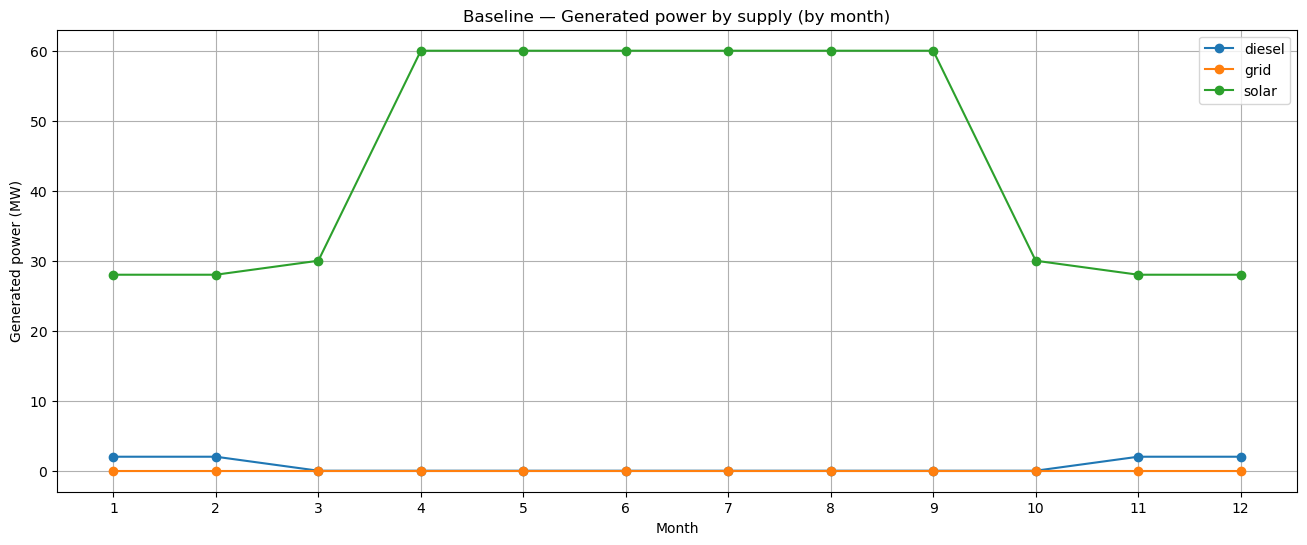

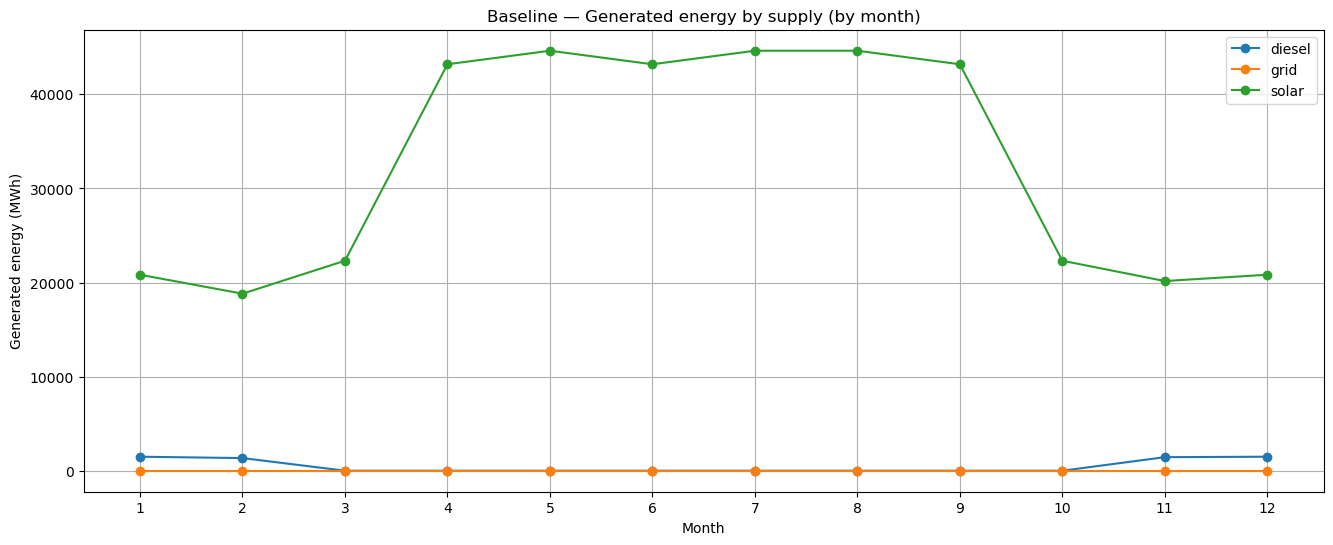

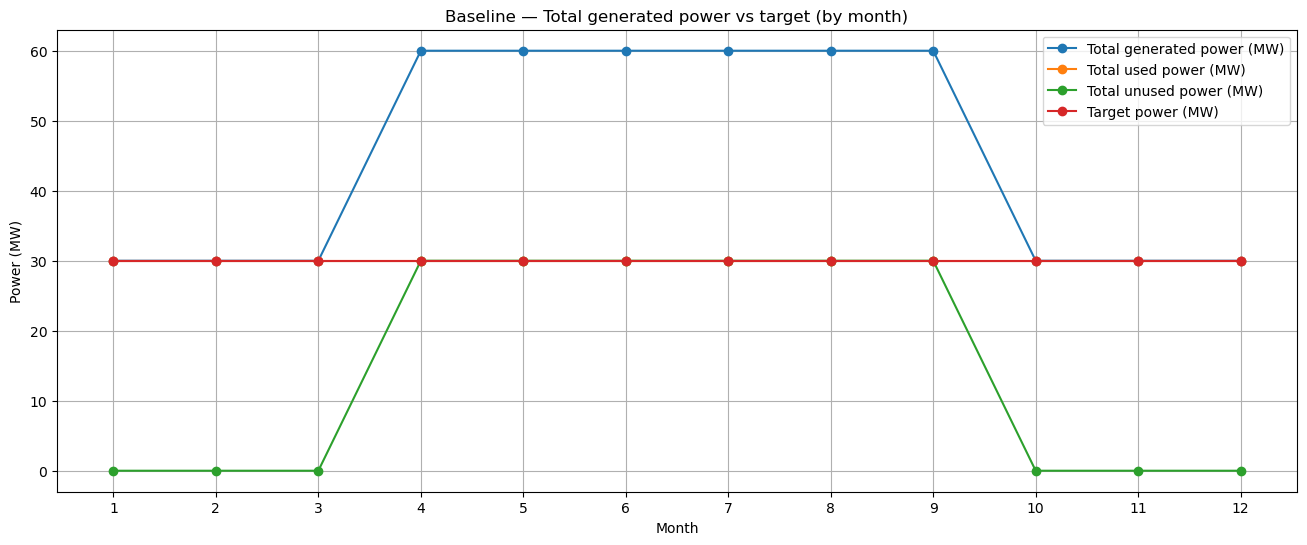

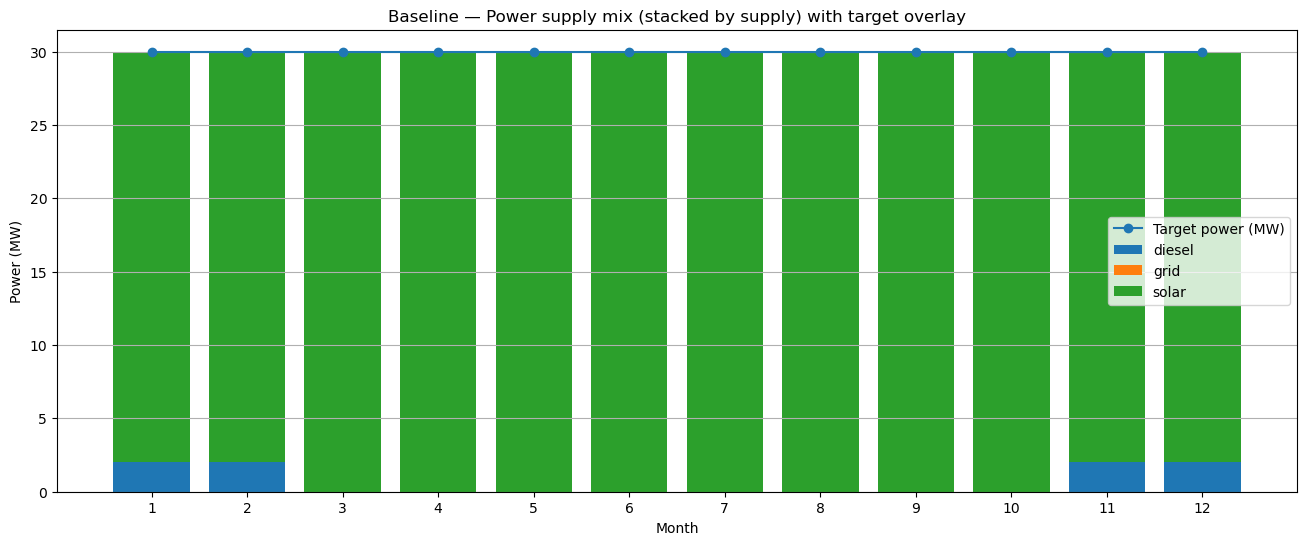

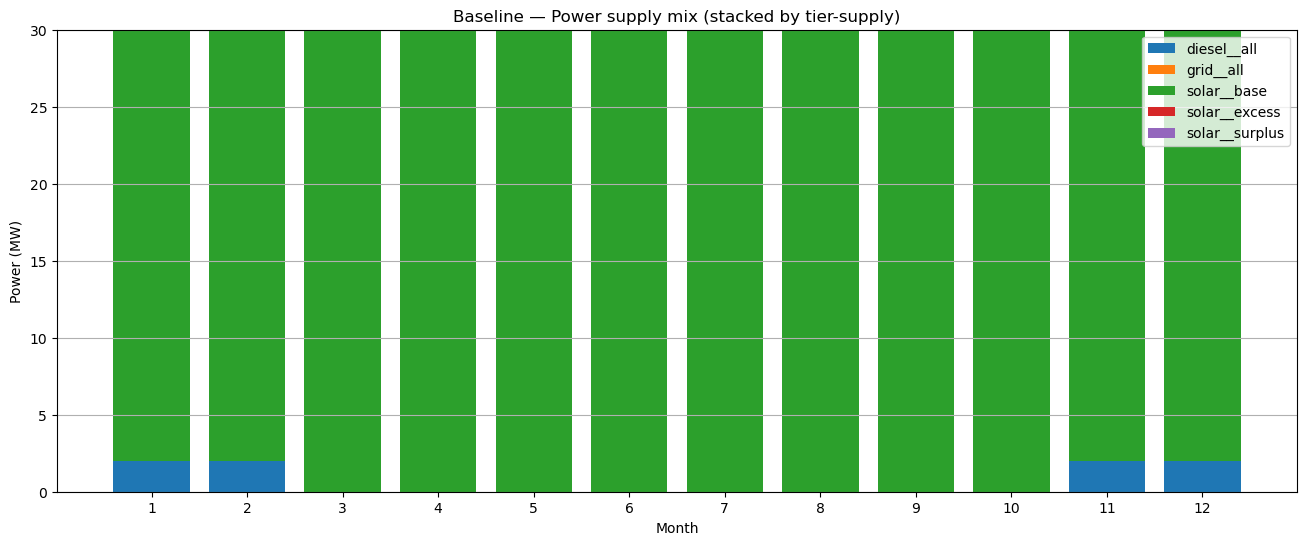

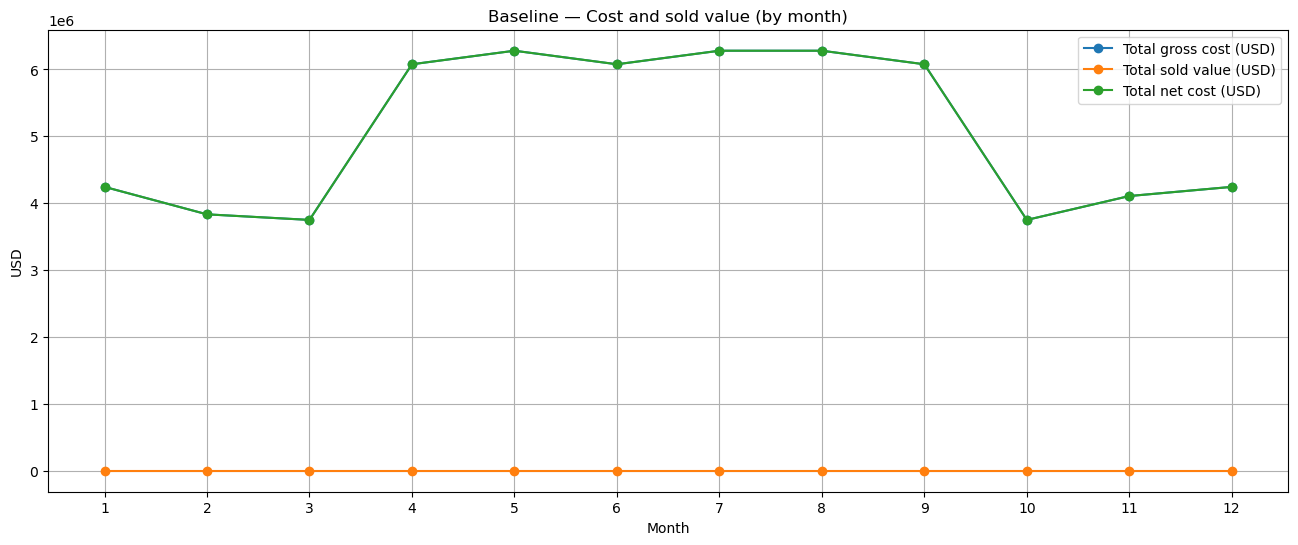

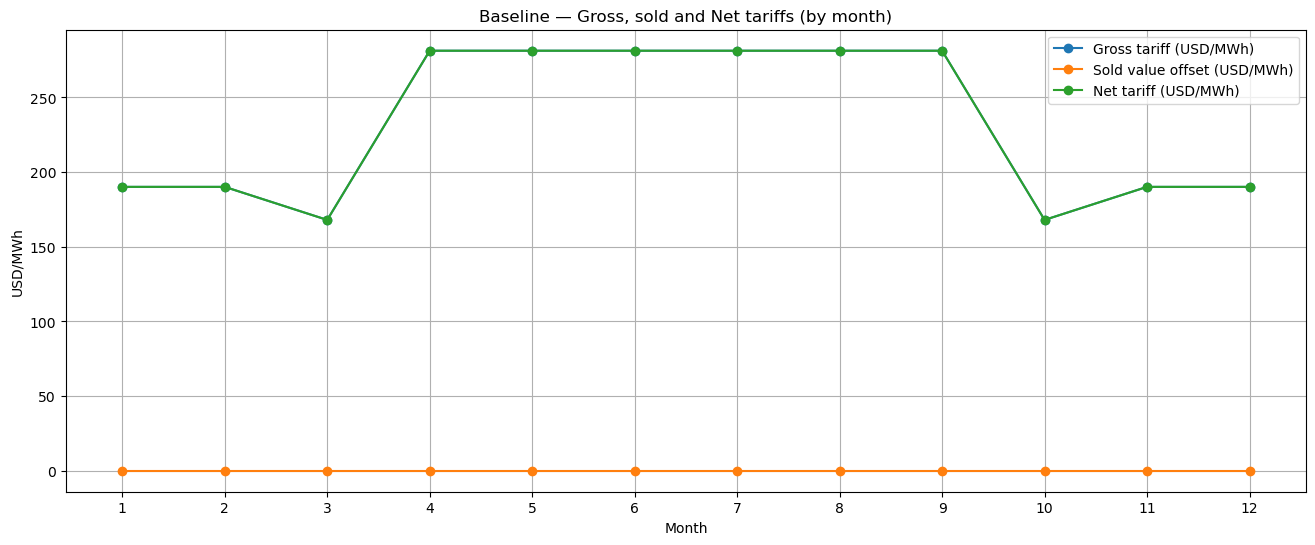

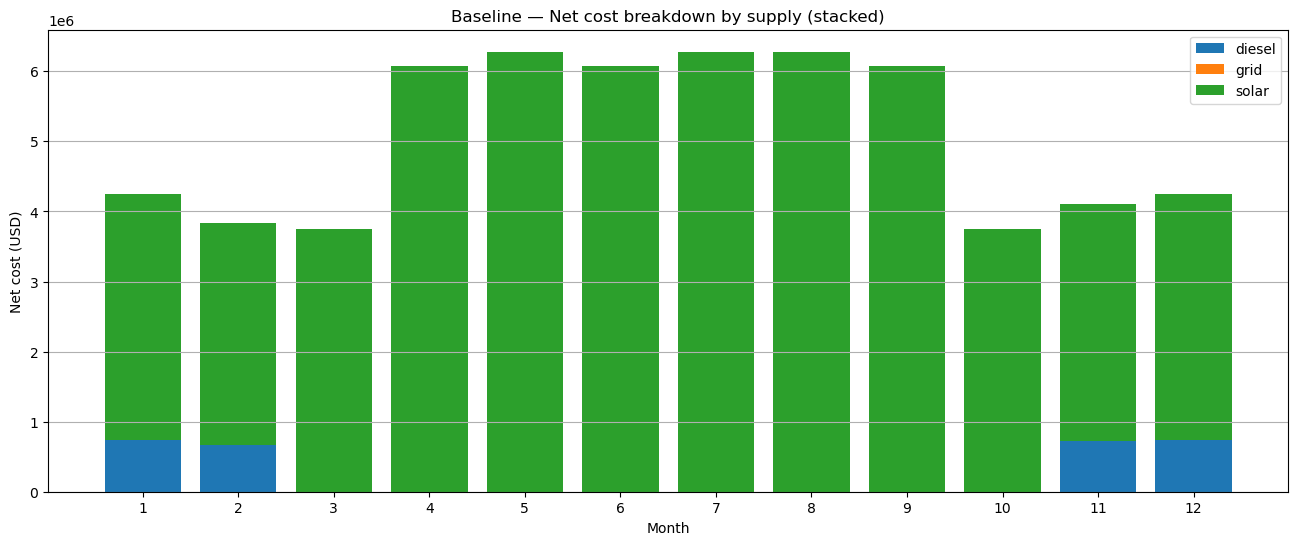

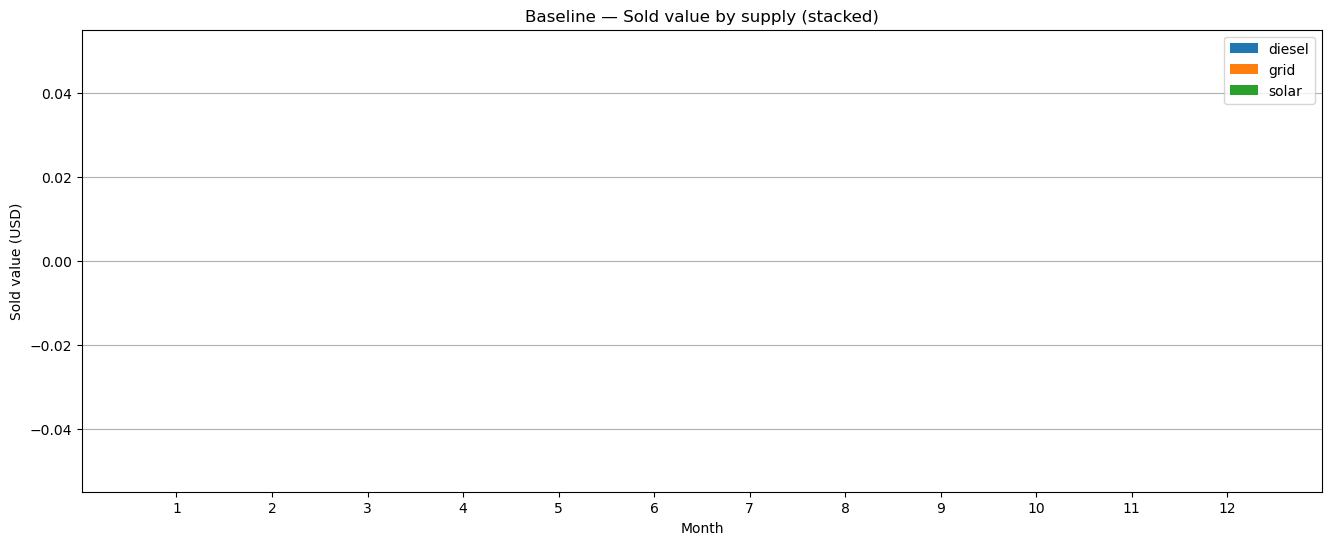

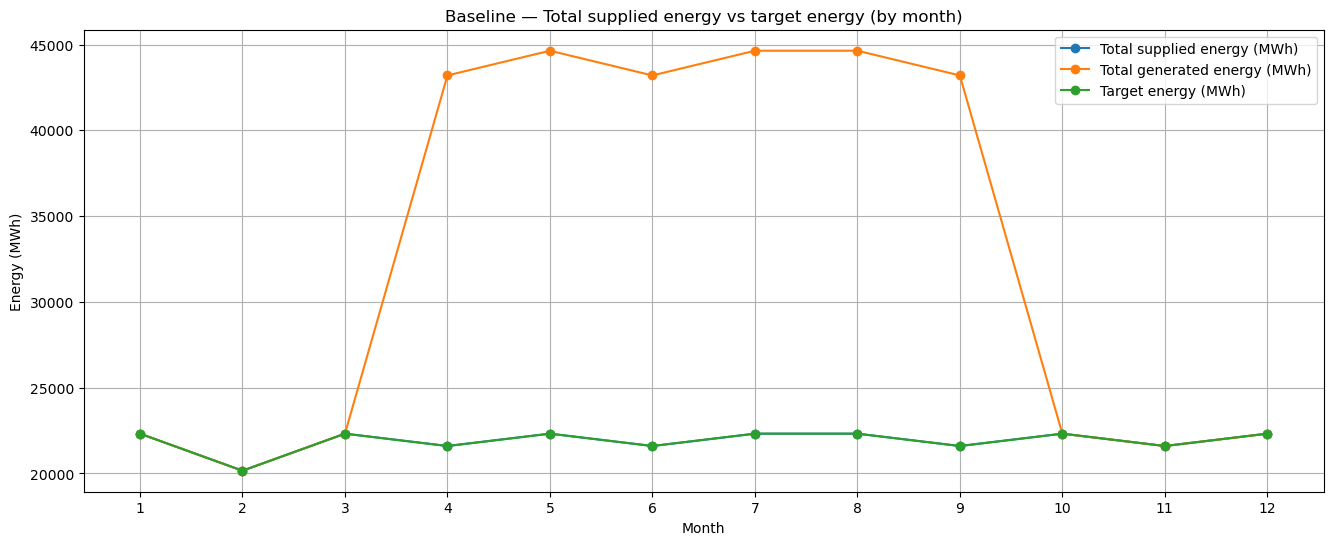

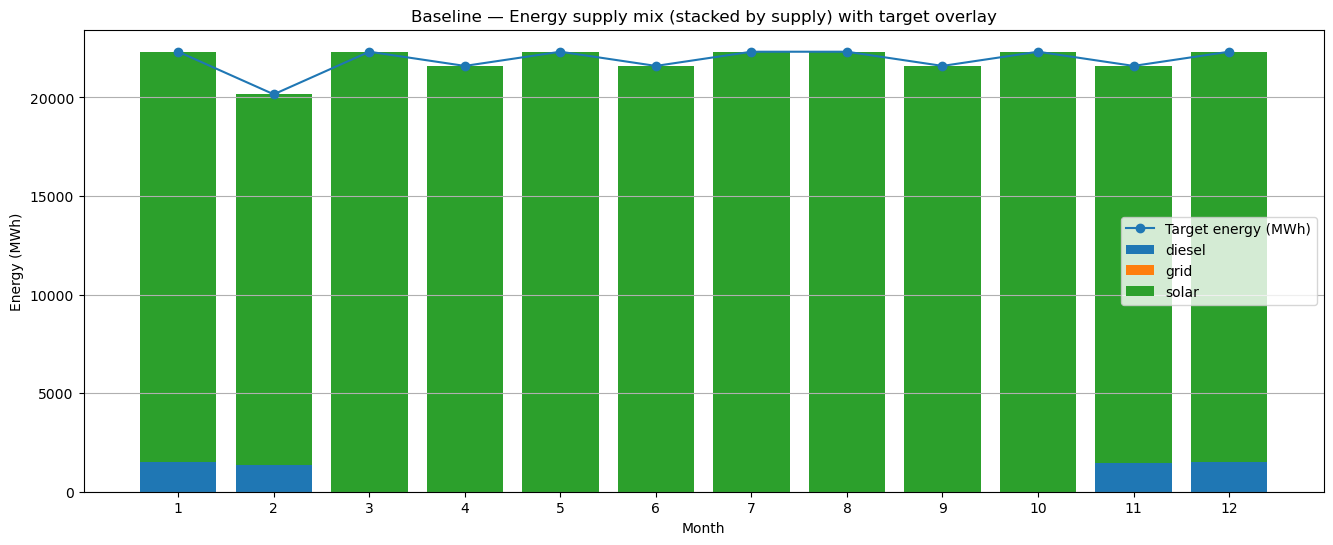

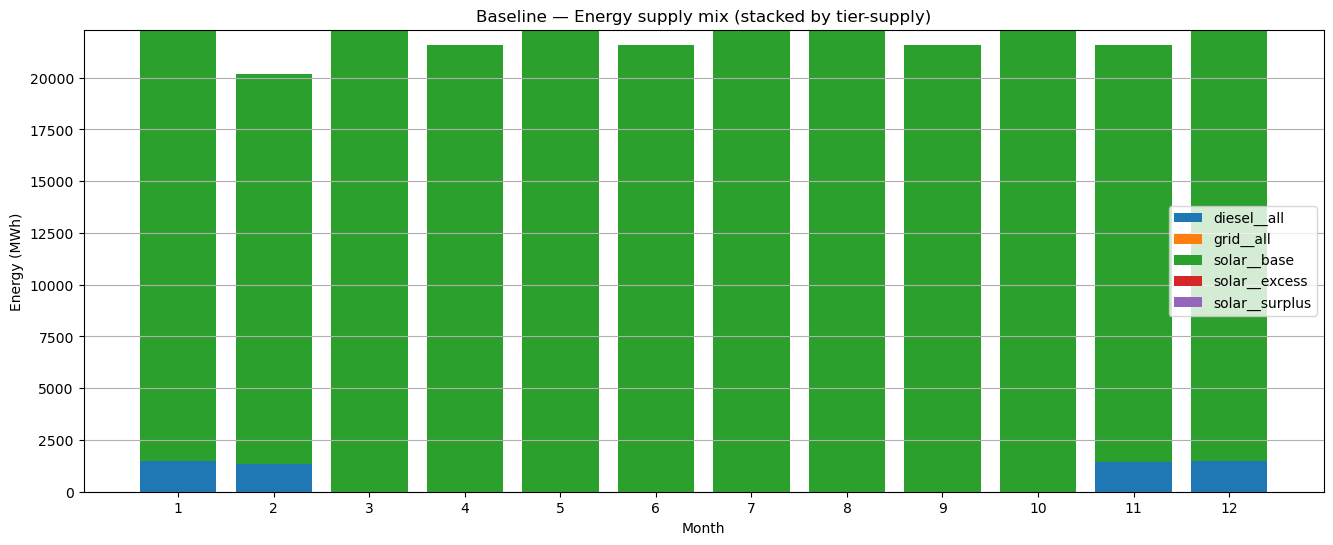

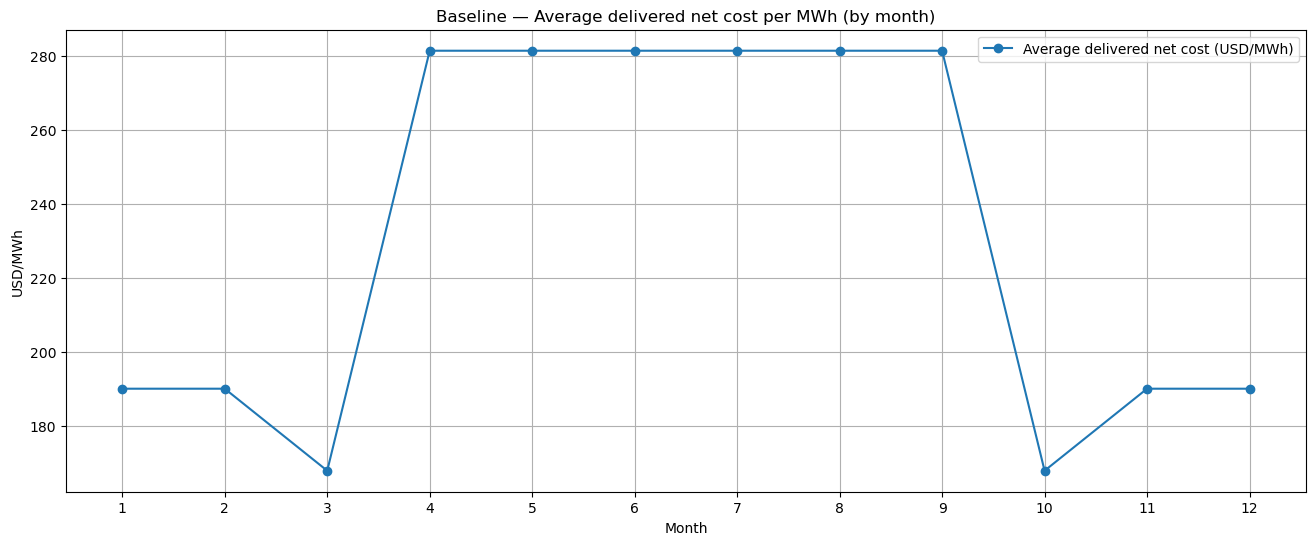

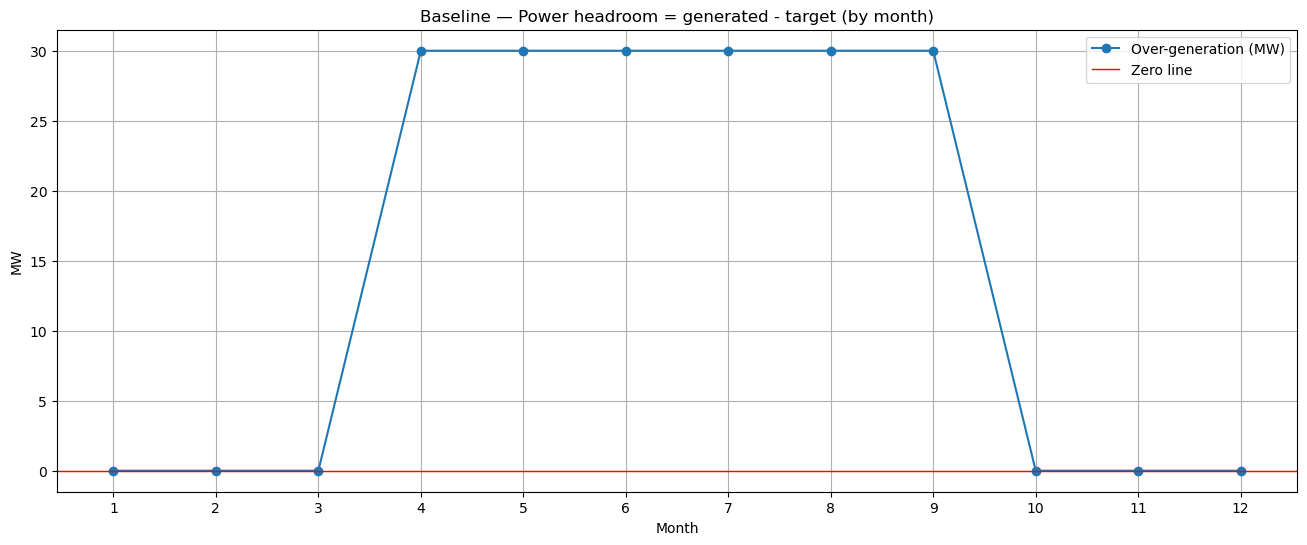

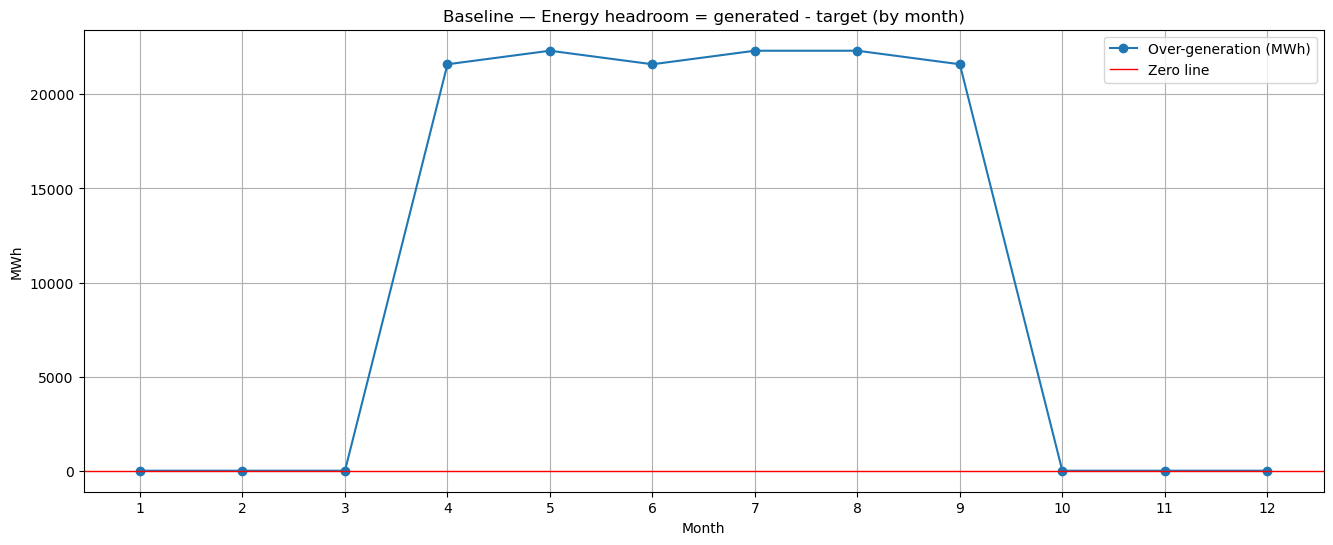

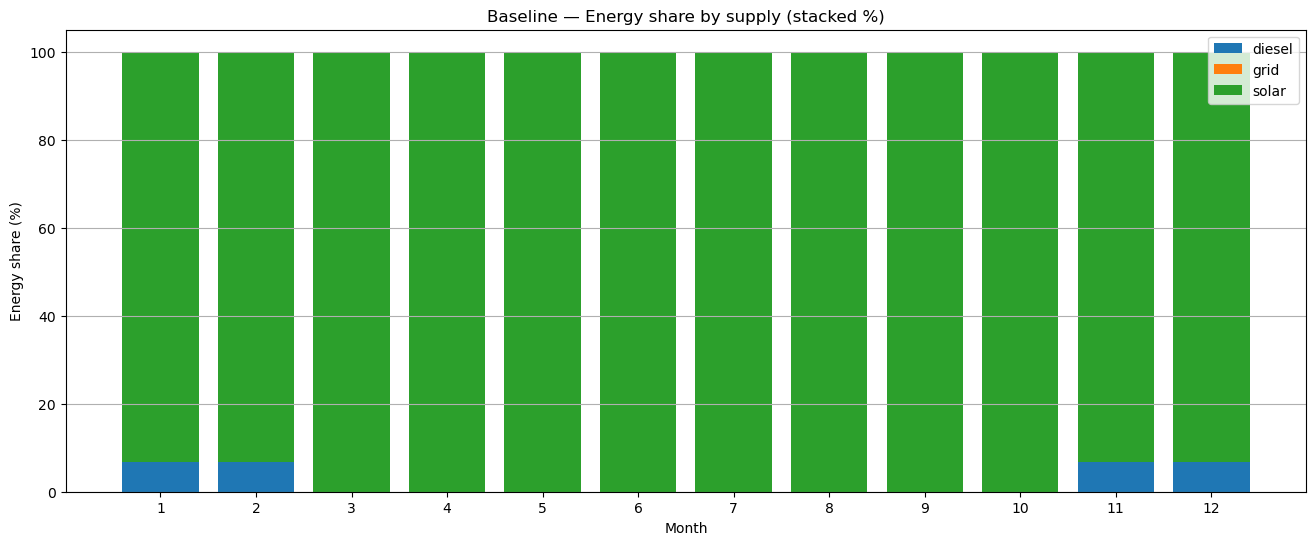

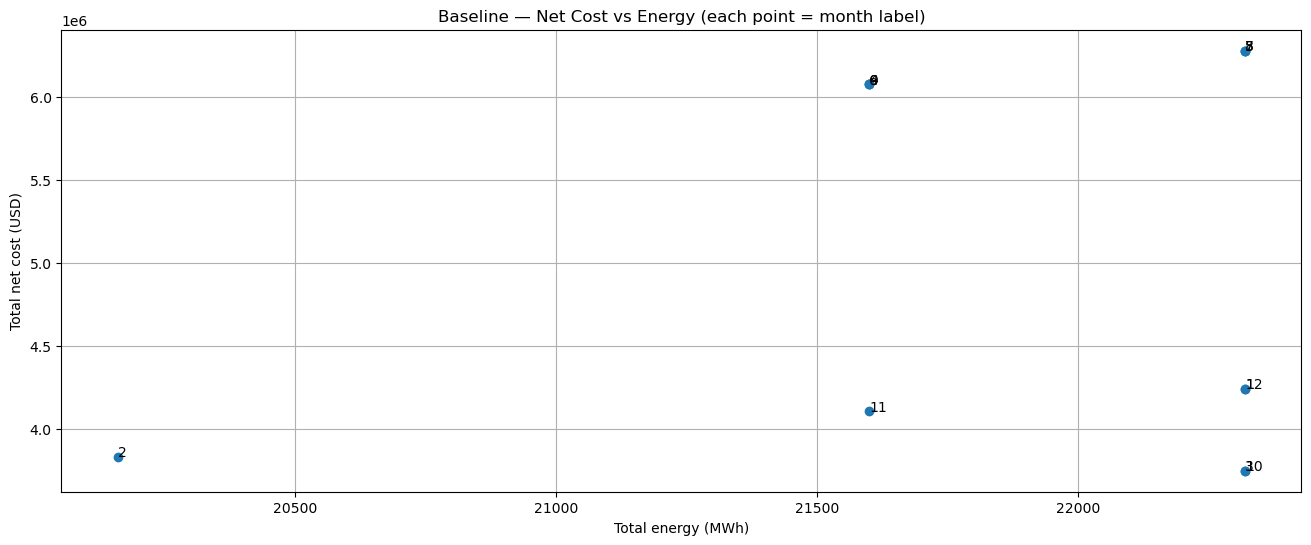

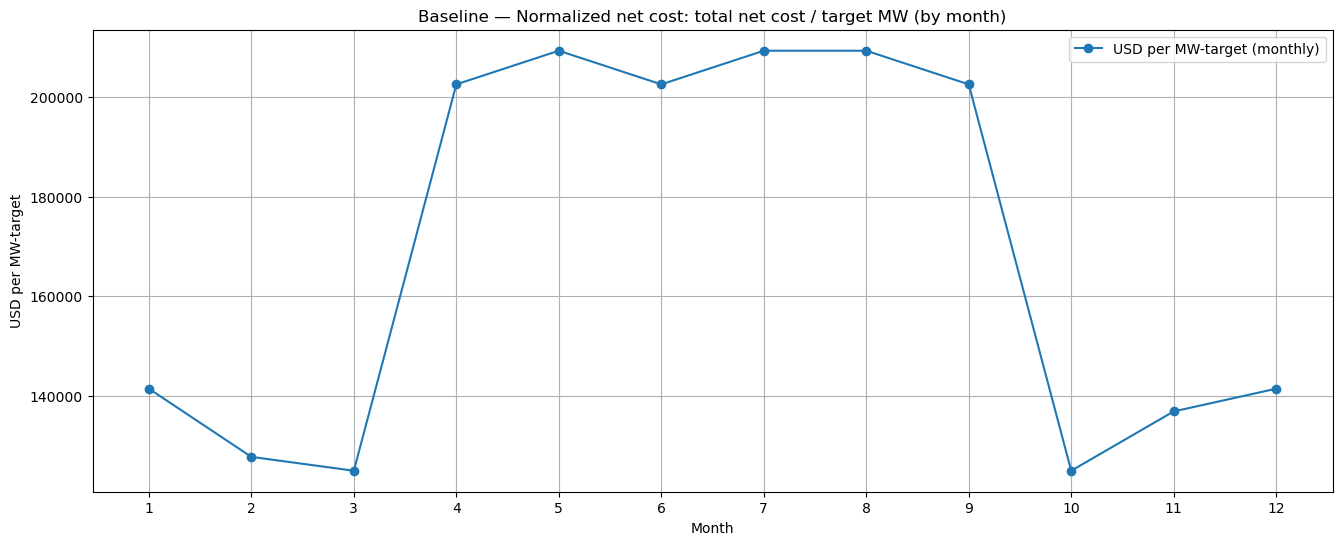

In [38]:
# Cell 9 — Plots (tier-aware + sold value)
# Run AFTER Cell 6 (requires: df, T_MW, H, months)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

scenario_name = globals().get("active_scenario_name") or "Scenario"
title_prefix = f"{scenario_name} — "

plt.rcParams["figure.figsize"] = (16, 6)   # width, height in inches

months_sorted = sorted(df["month"].unique())

# --- Prepare pivots (USED) ---
power_pivot_supply = df.pivot_table(index="month", columns="supply", values="Power_MW", aggfunc="sum").fillna(0)
energy_pivot_supply = df.pivot_table(index="month", columns="supply", values="Energy_MWh", aggfunc="sum").fillna(0)

power_pivot_tier = df.pivot_table(index="month", columns="tier_supply", values="Power_MW", aggfunc="sum").fillna(0)
energy_pivot_tier = df.pivot_table(index="month", columns="tier_supply", values="Energy_MWh", aggfunc="sum").fillna(0)

# --- Prepare pivots (GENERATED) ---
gen_power_pivot_supply = df.pivot_table(index="month", columns="supply", values="Generated_MW", aggfunc="sum").fillna(0)
gen_energy_pivot_supply = df.pivot_table(index="month", columns="supply", values="Generated_MWh", aggfunc="sum").fillna(0)

# --- Costs / sold value ---
net_cost_pivot_supply = df.pivot_table(index="month", columns="supply", values="NetCost_USD", aggfunc="sum").fillna(0)
gross_cost_pivot_supply = df.pivot_table(index="month", columns="supply", values="GrossCost_USD", aggfunc="sum").fillna(0)
sold_value_pivot_supply = df.pivot_table(index="month", columns="supply", values="SoldValue_USD", aggfunc="sum").fillna(0)

# Targets
target_power = pd.Series({m: T_MW[m] for m in months_sorted}).sort_index()          # MW
hours_series = pd.Series({m: H[m] for m in months_sorted}).sort_index()            # hours
target_energy = target_power * hours_series                                        # MWh

# Totals (USED)
total_power = power_pivot_supply.sum(axis=1).reindex(months_sorted)                # MW
total_energy = energy_pivot_supply.sum(axis=1).reindex(months_sorted)              # MWh

# Totals (GENERATED)
total_generated_power = gen_power_pivot_supply.sum(axis=1).reindex(months_sorted)  # MW
total_generated_energy = gen_energy_pivot_supply.sum(axis=1).reindex(months_sorted)  # MWh

# Totals (COST)
total_net_cost = net_cost_pivot_supply.sum(axis=1).reindex(months_sorted)
total_gross_cost = gross_cost_pivot_supply.sum(axis=1).reindex(months_sorted)
total_sold_value = sold_value_pivot_supply.sum(axis=1).reindex(months_sorted)


def stacked_bar(pivot_df: pd.DataFrame, title: str, ylabel: str, overlay_line=None, overlay_label=None):
    plt.figure()
    bottom = np.zeros(len(months_sorted))
    pivot_df = pivot_df.reindex(months_sorted).fillna(0)

    for col in pivot_df.columns:
        vals = pivot_df[col].values
        plt.bar(months_sorted, vals, bottom=bottom, label=str(col))
        bottom += vals

    if overlay_line is not None:
        plt.plot(months_sorted, overlay_line.reindex(months_sorted).values, marker="o", label=overlay_label)

    plt.xticks(months_sorted)
    plt.xlabel("Month")
    plt.ylabel(ylabel)
    plt.title(f"{title_prefix}{title}")

    handles, labels = plt.gca().get_legend_handles_labels()
    if labels:
        plt.legend()

    plt.grid(True, axis="y")
    plt.show()


# 0) Generated power by supply (lines)
plt.figure()
_p = gen_power_pivot_supply.reindex(months_sorted).fillna(0)
for col in _p.columns:
    plt.plot(months_sorted, _p[col].values, marker="o", label=str(col))
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Generated power (MW)")
plt.title(f"{title_prefix}Generated power by supply (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 0b) Generated energy by supply (lines)
plt.figure()
_e = gen_energy_pivot_supply.reindex(months_sorted).fillna(0)
for col in _e.columns:
    plt.plot(months_sorted, _e[col].values, marker="o", label=str(col))
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Generated energy (MWh)")
plt.title(f"{title_prefix}Generated energy by supply (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 1) Total generated power vs target power
# Calculate unused power (generated - used)
total_unused_power = total_generated_power - total_power

plt.figure()
plt.plot(months_sorted, total_generated_power.values, marker="o", label="Total generated power (MW)")
plt.plot(months_sorted, total_power.values, marker="o", label="Total used power (MW)")
plt.plot(months_sorted, total_unused_power.values, marker="o", label="Total unused power (MW)")
plt.plot(months_sorted, target_power.values, marker="o", label="Target power (MW)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Power (MW)")
plt.title(f"{title_prefix}Total generated power vs target (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 1b) Power supply mix (stacked by SUPPLY) + target overlay (USED)
stacked_bar(
    power_pivot_supply,
    title="Power supply mix (stacked by supply) with target overlay",
    ylabel="Power (MW)",
    overlay_line=target_power,
    overlay_label="Target power (MW)",
)

# 1c) Power supply mix (stacked by TIER-SUPPLY) (USED)
stacked_bar(
    power_pivot_tier,
    title="Power supply mix (stacked by tier-supply)",
    ylabel="Power (MW)",
)

# 2) Net cost and sold value by month
plt.figure()
plt.plot(months_sorted, total_gross_cost.values, marker="o", label="Total gross cost (USD)")
plt.plot(months_sorted, total_sold_value.values, marker="o", label="Total sold value (USD)")
plt.plot(months_sorted, total_net_cost.values, marker="o", label="Total net cost (USD)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("USD")
plt.title(f"{title_prefix}Cost and sold value (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 2a) Gross, sold and net tariffs (by month) (USD/MWh on USED energy)
gross_tariff = (total_gross_cost / total_energy).replace([np.inf, -np.inf], np.nan)
sold_tariff = (total_sold_value / total_energy).replace([np.inf, -np.inf], np.nan)
net_tariff = (total_net_cost / total_energy).replace([np.inf, -np.inf], np.nan)

plt.figure()
plt.plot(months_sorted, gross_tariff.values, marker="o", label="Gross tariff (USD/MWh)")
plt.plot(months_sorted, sold_tariff.values, marker="o", label="Sold value offset (USD/MWh)")
plt.plot(months_sorted, net_tariff.values, marker="o", label="Net tariff (USD/MWh)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("USD/MWh")
plt.title(f"{title_prefix}Gross, sold and Net tariffs (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 2b) Net cost breakdown by supply (stacked)
stacked_bar(
    net_cost_pivot_supply,
    title="Net cost breakdown by supply (stacked)",
    ylabel="Net cost (USD)",
)

# 2c) Sold value by supply (stacked)
stacked_bar(
    sold_value_pivot_supply,
    title="Sold value by supply (stacked)",
    ylabel="Sold value (USD)",
)

# 3) Total supplied energy vs target energy (include total generated energy)
plt.figure()
plt.plot(months_sorted, total_energy.values, marker="o", label="Total supplied energy (MWh)")
plt.plot(months_sorted, total_generated_energy.values, marker="o", label="Total generated energy (MWh)")
plt.plot(months_sorted, target_energy.values, marker="o", label="Target energy (MWh)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Energy (MWh)")
plt.title(f"{title_prefix}Total supplied energy vs target energy (by month)")
plt.legend()
plt.grid(True)
plt.show()

# 3b) Energy mix (stacked by SUPPLY) + target overlay (USED)
stacked_bar(
    energy_pivot_supply,
    title="Energy supply mix (stacked by supply) with target overlay",
    ylabel="Energy (MWh)",
    overlay_line=target_energy,
    overlay_label="Target energy (MWh)",
)

# 3c) Energy mix (stacked by TIER-SUPPLY) (USED)
stacked_bar(
    energy_pivot_tier,
    title="Energy supply mix (stacked by tier-supply)",
    ylabel="Energy (MWh)",
)

# A) Average delivered unit cost (USD/MWh) each month (NET on USED energy)
avg_unit_cost = (total_net_cost / total_energy).replace([np.inf, -np.inf], np.nan)
plt.figure()
plt.plot(months_sorted, avg_unit_cost.values, marker="o", label="Average delivered net cost (USD/MWh)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("USD/MWh")
plt.title(f"{title_prefix}Average delivered net cost per MWh (by month)")
plt.legend()
plt.grid(True)
plt.show()

# B) Over-generation above target (MW and MWh) (on GENERATED)
power_margin = total_generated_power - target_power
energy_margin = total_generated_energy - target_energy

plt.figure()
plt.plot(months_sorted, power_margin.values, marker="o", label="Over-generation (MW)")
plt.axhline(0, color='red', linestyle='-', linewidth=1, label='Zero line')
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("MW")
plt.title(f"{title_prefix}Power headroom = generated - target (by month)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(months_sorted, energy_margin.values, marker="o", label="Over-generation (MWh)")
plt.axhline(0, color='red', linestyle='-', linewidth=1, label='Zero line')
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("MWh")
plt.title(f"{title_prefix}Energy headroom = generated - target (by month)")
plt.legend()
plt.grid(True)
plt.show()

# C) Energy share (%) by supply (stacked) (USED)
energy_share_pct = energy_pivot_supply.div(energy_pivot_supply.sum(axis=1), axis=0).fillna(0).reindex(months_sorted) * 100.0

plt.figure()
bottom = np.zeros(len(months_sorted))
for s in energy_share_pct.columns:
    vals = energy_share_pct[s].values
    plt.bar(months_sorted, vals, bottom=bottom, label=str(s))
    bottom += vals
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("Energy share (%)")
plt.title(f"{title_prefix}Energy share by supply (stacked %)")
plt.legend()
plt.grid(True, axis="y")
plt.show()

# D) Correlation-style view: Net Cost vs Energy (by month) (USED)
plt.figure()
plt.scatter(total_energy.values, total_net_cost.values)
for i, m in enumerate(months_sorted):
    plt.annotate(str(m), (total_energy.values[i], total_net_cost.values[i]))
plt.xlabel("Total energy (MWh)")
plt.ylabel("Total net cost (USD)")
plt.title(f"{title_prefix}Net Cost vs Energy (each point = month label)")
plt.grid(True)
plt.show()

# E) Monthly net cost per MW of target (useful normalization)
cost_per_target_mw = total_net_cost / target_power.replace(0, np.nan)
plt.figure()
plt.plot(months_sorted, cost_per_target_mw.values, marker="o", label="USD per MW-target (monthly)")
plt.xticks(months_sorted)
plt.xlabel("Month")
plt.ylabel("USD per MW-target")
plt.title(f"{title_prefix}Normalized net cost: total net cost / target MW (by month)")
plt.legend()
plt.grid(True)
plt.show()


## Yearly Aggregated Results

YEARLY SUMMARY
Total Energy Used (MWh):        262,800.00
Total Energy Generated (MWh):   394,560.00
Target Energy (MWh):            262,800.00
Total Gross Cost (USD):         60,995,520.00
Total Sold Value (USD):         0.00
Total Net Cost (USD):           60,995,520.00
Average Gross Tariff (USD/MWh): 232.10
Average Sold Offset (USD/MWh):  0.00
Average Net Tariff (USD/MWh):   232.10


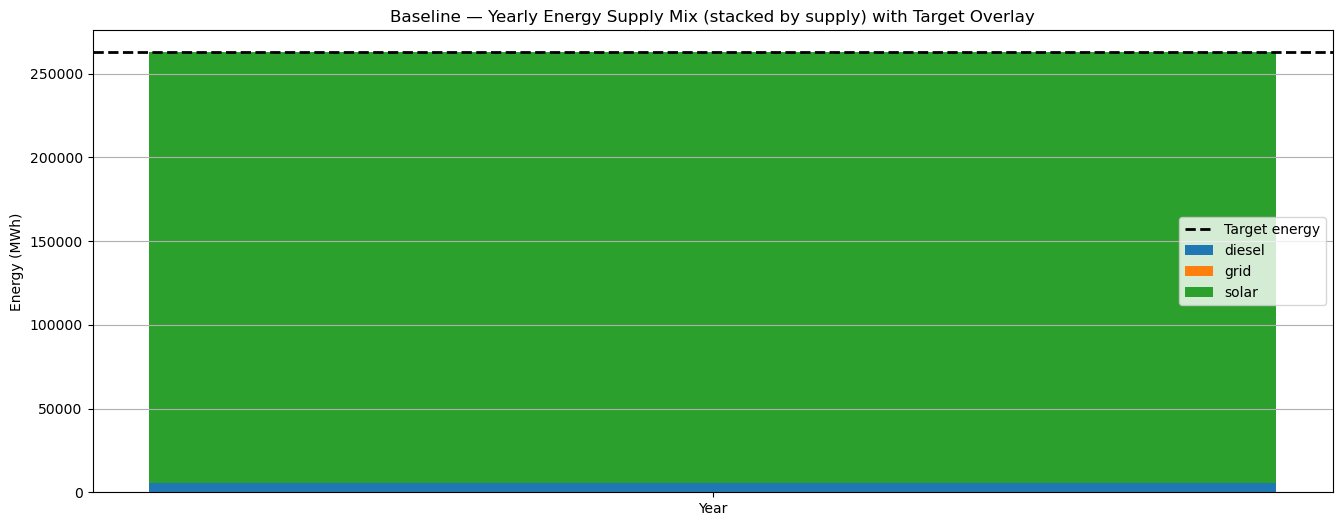

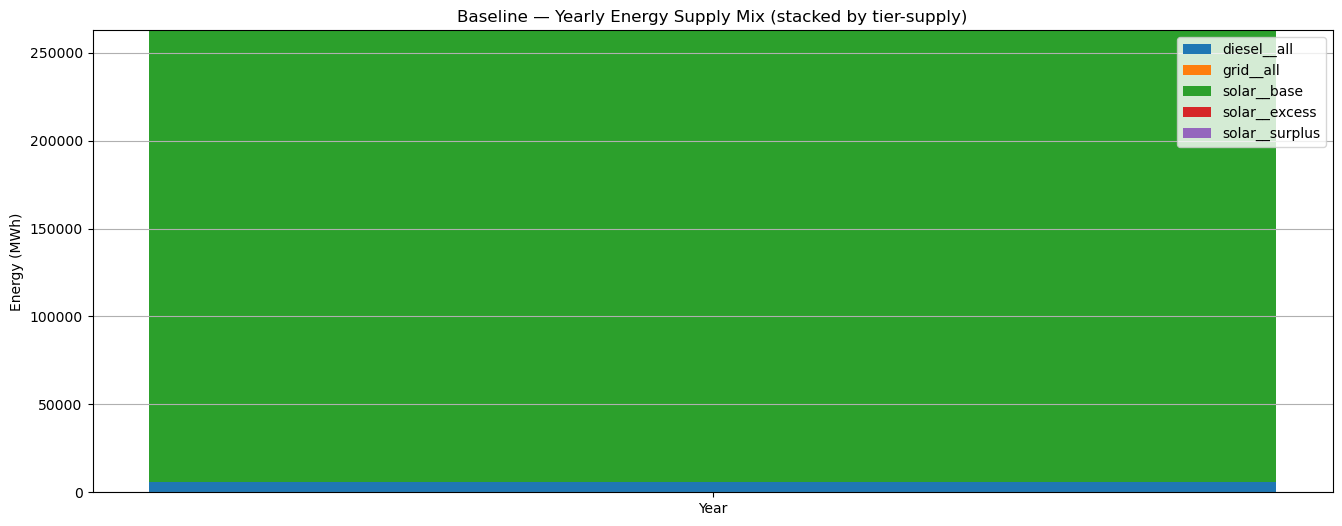

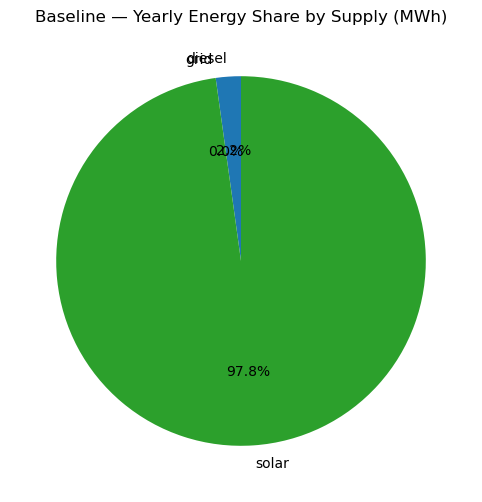

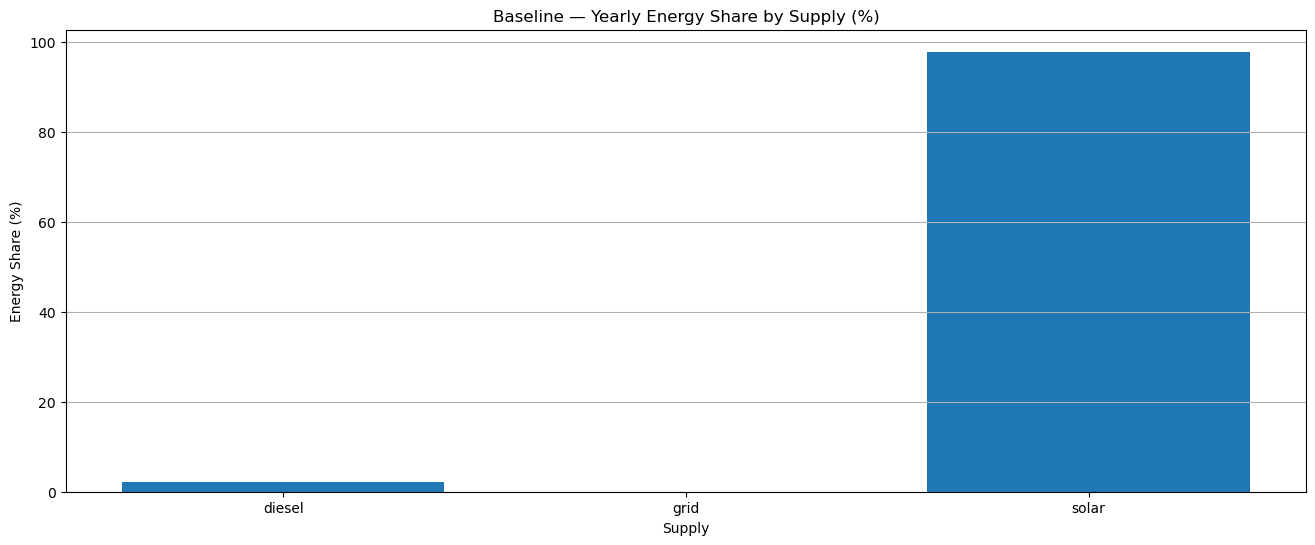

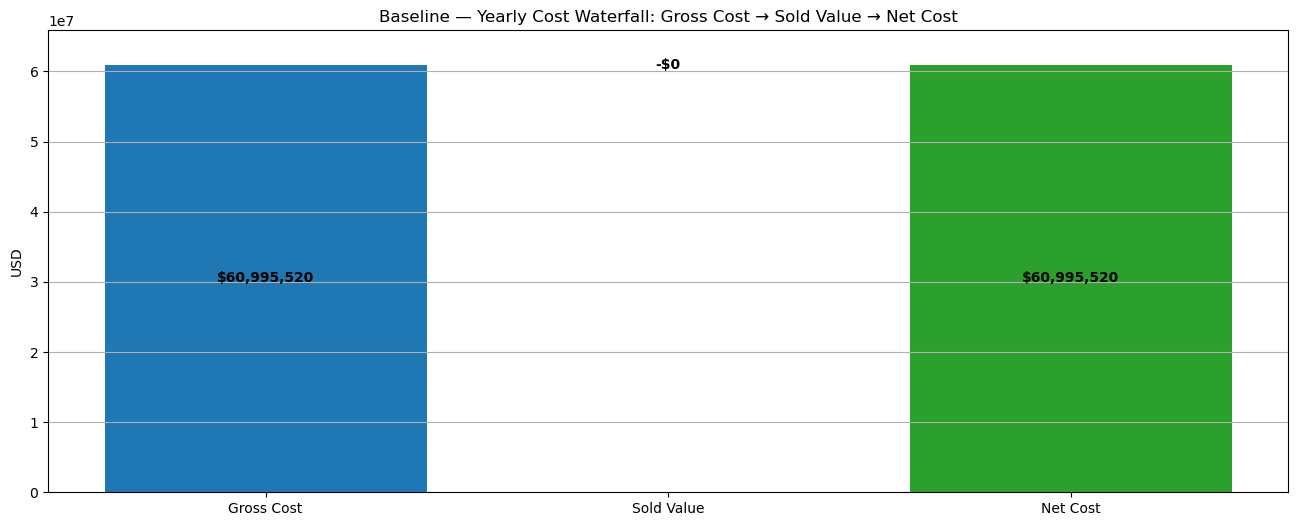

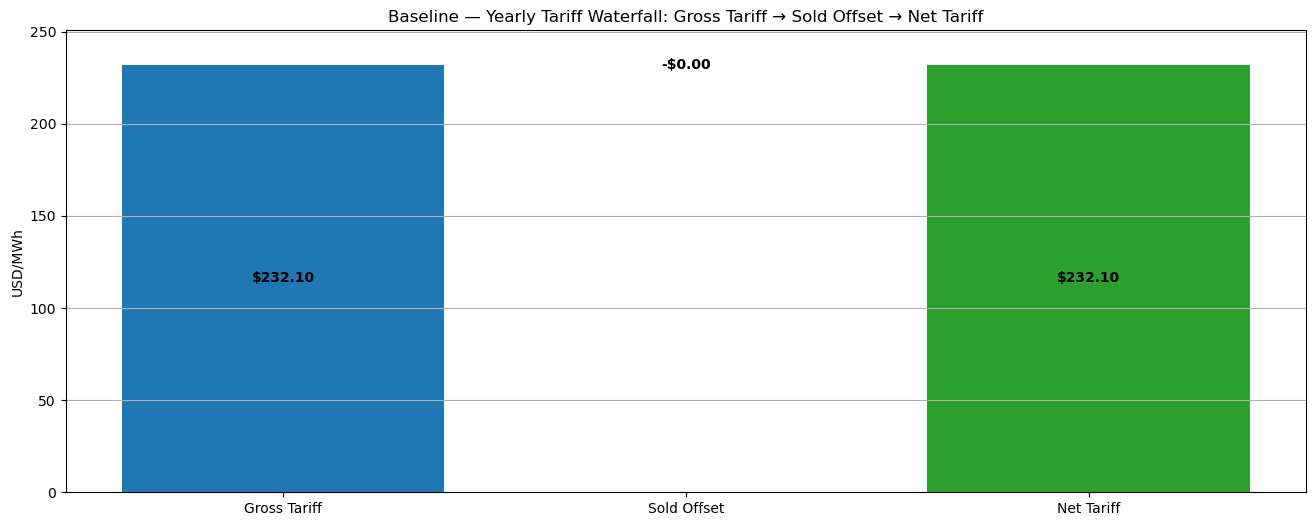


Yearly Summary by Supply:


,supply,TotalEnergy_MWh,TotalGeneratedEnergy_MWh,TotalSoldEnergy_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD
0,diesel,5760.0,5760.0,0.0,2880000.0,0.0,2880000.0
1,grid,0.0,0.0,0.0,0.0,0.0,0.0
2,solar,257040.0,388800.0,0.0,58115520.0,0.0,58115520.0



Yearly Summary by Tier-Supply:


,tier_supply,TotalEnergy_MWh,TotalGeneratedEnergy_MWh,TotalSoldEnergy_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD
0,diesel__all,5760.0,5760.0,0.0,2880000.0,0.0,2880000.0
1,grid__all,0.0,0.0,0.0,0.0,0.0,0.0
2,solar__base,257040.0,257040.0,0.0,43182720.0,0.0,43182720.0
3,solar__excess,0.0,43920.0,0.0,0.0,0.0,0.0
4,solar__surplus,0.0,87840.0,0.0,14932800.0,0.0,14932800.0


In [39]:
# Cell 11 — Yearly Aggregated Results
# Run AFTER Cell 9 (requires: df, energy_pivot_supply, energy_pivot_tier, T_MW, H, months)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

scenario_name = globals().get("active_scenario_name") or "Scenario"
title_prefix = f"{scenario_name} — "

# Aggregate data for the year
yearly_summary = df.groupby("supply", as_index=False).agg(
    TotalEnergy_MWh=("Energy_MWh", "sum"),
    TotalGeneratedEnergy_MWh=("Generated_MWh", "sum"),
    TotalSoldEnergy_MWh=("Sold_MWh", "sum"),
    TotalGrossCost_USD=("GrossCost_USD", "sum"),
    TotalSoldValue_USD=("SoldValue_USD", "sum"),
    TotalNetCost_USD=("NetCost_USD", "sum"),
)

yearly_summary_tier = df.groupby("tier_supply", as_index=False).agg(
    TotalEnergy_MWh=("Energy_MWh", "sum"),
    TotalGeneratedEnergy_MWh=("Generated_MWh", "sum"),
    TotalSoldEnergy_MWh=("Sold_MWh", "sum"),
    TotalGrossCost_USD=("GrossCost_USD", "sum"),
    TotalSoldValue_USD=("SoldValue_USD", "sum"),
    TotalNetCost_USD=("NetCost_USD", "sum"),
)

# Calculate yearly target
yearly_target_energy = sum(T_MW[m] * H[m] for m in months)

# Total yearly values
total_yearly_energy = yearly_summary["TotalEnergy_MWh"].sum()
total_yearly_generated = yearly_summary["TotalGeneratedEnergy_MWh"].sum()
total_yearly_gross_cost = yearly_summary["TotalGrossCost_USD"].sum()
total_yearly_sold_value = yearly_summary["TotalSoldValue_USD"].sum()
total_yearly_net_cost = yearly_summary["TotalNetCost_USD"].sum()

# Calculate average tariffs
avg_gross = total_yearly_gross_cost / total_yearly_energy if total_yearly_energy > 0 else 0
avg_sold = total_yearly_sold_value / total_yearly_energy if total_yearly_energy > 0 else 0
avg_net = total_yearly_net_cost / total_yearly_energy if total_yearly_energy > 0 else 0

print("=" * 60)
print("YEARLY SUMMARY")
print("=" * 60)
print(f"Total Energy Used (MWh):        {total_yearly_energy:,.2f}")
print(f"Total Energy Generated (MWh):   {total_yearly_generated:,.2f}")
print(f"Target Energy (MWh):            {yearly_target_energy:,.2f}")
print(f"Total Gross Cost (USD):         {total_yearly_gross_cost:,.2f}")
print(f"Total Sold Value (USD):         {total_yearly_sold_value:,.2f}")
print(f"Total Net Cost (USD):           {total_yearly_net_cost:,.2f}")
print(f"Average Gross Tariff (USD/MWh): {avg_gross:.2f}")
print(f"Average Sold Offset (USD/MWh):  {avg_sold:.2f}")
print(f"Average Net Tariff (USD/MWh):   {avg_net:.2f}")
print("=" * 60)

plt.rcParams["figure.figsize"] = (16, 6)

# 1) Energy supply mix (stacked by supply) with target overlay
plt.figure()
supplies_list = yearly_summary["supply"].tolist()
energy_by_supply = yearly_summary["TotalEnergy_MWh"].values
bottom = 0
for i, supply in enumerate(supplies_list):
    plt.bar(["Year"], energy_by_supply[i], bottom=bottom, label=supply)
    bottom += energy_by_supply[i]
plt.axhline(yearly_target_energy, color='black', linestyle='--', linewidth=2, label='Target energy')
plt.ylabel("Energy (MWh)")
plt.title(f"{title_prefix}Yearly Energy Supply Mix (stacked by supply) with Target Overlay")
plt.legend()
plt.grid(True, axis="y")
plt.show()

# 2) Energy supply mix (stacked by tier-supply)
plt.figure()
tier_supplies_list = yearly_summary_tier["tier_supply"].tolist()
energy_by_tier = yearly_summary_tier["TotalEnergy_MWh"].values
bottom = 0
for i, tier in enumerate(tier_supplies_list):
    plt.bar(["Year"], energy_by_tier[i], bottom=bottom, label=tier)
    bottom += energy_by_tier[i]
plt.ylabel("Energy (MWh)")
plt.title(f"{title_prefix}Yearly Energy Supply Mix (stacked by tier-supply)")
plt.legend()
plt.grid(True, axis="y")
plt.show()

# 3) Energy share by supply (MWh) - pie chart
plt.figure()
plt.pie(yearly_summary["TotalEnergy_MWh"], labels=yearly_summary["supply"], autopct='%1.1f%%', startangle=90)
plt.title(f"{title_prefix}Yearly Energy Share by Supply (MWh)")
plt.show()

# 4) Energy share by supply (%) - bar chart
plt.figure()
energy_share_pct_yearly = (yearly_summary["TotalEnergy_MWh"] / total_yearly_energy * 100).values
plt.bar(supplies_list, energy_share_pct_yearly)
plt.ylabel("Energy Share (%)")
plt.xlabel("Supply")
plt.title(f"{title_prefix}Yearly Energy Share by Supply (%)")
plt.grid(True, axis="y")
plt.show()

# 5) Waterfall chart for total gross cost / sold value / net cost (USD)
plt.figure()
categories = ["Gross Cost", "Sold Value", "Net Cost"]
x = np.arange(len(categories))

gross = float(total_yearly_gross_cost)
sold = float(total_yearly_sold_value)
net = float(total_yearly_net_cost)

# Draw as: gross (from 0), sold step (drop from gross to gross-sold), net total (from 0)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
plt.bar(x[0], gross, color=colors[0])
plt.bar(x[1], -sold, bottom=gross, color=colors[1])
plt.bar(x[2], net, color=colors[2])

plt.xticks(x, categories)
plt.ylabel("USD")
plt.title(f"{title_prefix}Yearly Cost Waterfall: Gross Cost → Sold Value → Net Cost")

# Add headroom above the highest step
y_max = max(gross, net, gross)
y_min = min(0.0, gross - sold, net)
y_pad = max(1.0, (y_max - y_min) * 0.08)
plt.ylim(y_min, y_max + y_pad)

# Value labels
plt.text(x[0], gross / 2, f"${gross:,.0f}", ha='center', va='center', fontsize=10, fontweight='bold')
plt.text(x[1], gross - sold / 2, f"-${sold:,.0f}", ha='center', va='center', fontsize=10, fontweight='bold')
plt.text(x[2], net / 2, f"${net:,.0f}", ha='center', va='center', fontsize=10, fontweight='bold')

plt.grid(True, axis="y")
plt.show()

# 6) Waterfall chart for gross tariff / sold value offset / net tariff (USD/MWh)
plt.figure()
categories_tariff = ["Gross Tariff", "Sold Offset", "Net Tariff"]
x2 = np.arange(len(categories_tariff))

gross_t = float(avg_gross)
sold_t = float(avg_sold)
net_t = float(avg_net)

colors_tariff = ["#1f77b4", "#ff7f0e", "#2ca02c"]
plt.bar(x2[0], gross_t, color=colors_tariff[0])
plt.bar(x2[1], -sold_t, bottom=gross_t, color=colors_tariff[1])
plt.bar(x2[2], net_t, color=colors_tariff[2])

plt.xticks(x2, categories_tariff)
plt.ylabel("USD/MWh")
plt.title(f"{title_prefix}Yearly Tariff Waterfall: Gross Tariff → Sold Offset → Net Tariff")

# Add headroom above the highest step
y2_max = max(gross_t, net_t, gross_t)
y2_min = min(0.0, gross_t - sold_t, net_t)
y2_pad = max(0.01, (y2_max - y2_min) * 0.08)
plt.ylim(y2_min, y2_max + y2_pad)

plt.text(x2[0], gross_t / 2, f"${gross_t:.2f}", ha='center', va='center', fontsize=10, fontweight='bold')
plt.text(x2[1], gross_t - sold_t / 2, f"-${sold_t:.2f}", ha='center', va='center', fontsize=10, fontweight='bold')
plt.text(x2[2], net_t / 2, f"${net_t:.2f}", ha='center', va='center', fontsize=10, fontweight='bold')

plt.grid(True, axis="y")
plt.show()

print("\nYearly Summary by Supply:")
display(yearly_summary)

print("\nYearly Summary by Tier-Supply:")
display(yearly_summary_tier)

# Scenario Differences
Compares scenarios against a baseline and shows deltas (Scenario − Baseline).

In [40]:
# Cell 15 — Scenario Differences

# Requires: scenario_results_active (preferred) or scenario_results
import numpy as np
import pandas as pd

sr = scenario_results_active if "scenario_results_active" in globals() else scenario_results

if "sr" not in locals() or not isinstance(sr, dict) or len(sr) == 0:
    raise RuntimeError("No scenario results found. Run Cell 6 first.")

scenario_names = list(sr.keys())
if len(scenario_names) < 2:
    print("Only one scenario present — nothing to compare.")
else:
    # Baseline: first scenario in the Cell 4 `scenarios` list (edit if needed)
    baseline_name = scenarios[0]["name"] if "scenarios" in globals() and len(scenarios) > 0 else scenario_names[0]
    if baseline_name not in sr:
        baseline_name = scenario_names[0]

    print(f"Baseline scenario: {baseline_name}")

    # Annual deltas (scenario-level summary)
    annual = scenario_summary.copy()
    annual_delta = annual.subtract(annual.loc[baseline_name], axis=1)

    print("\nAnnual totals (absolute):")
    display(annual.round(4))
    print("\nAnnual totals (Δ vs baseline):")
    display(annual_delta.round(4))

    # Monthly deltas: Net cost and used energy per month
    def monthly_totals(df_sc: pd.DataFrame) -> pd.DataFrame:
        out = (
            df_sc.groupby("month", as_index=False)
            .agg(
                Used_MWh=("Energy_MWh", "sum"),
                NetCost_USD=("NetCost_USD", "sum"),
                GrossCost_USD=("GrossCost_USD", "sum"),
                SoldValue_USD=("SoldValue_USD", "sum"),
            )
            .set_index("month")
            .sort_index()
        )
        out["NetTariff_USD_per_MWh"] = (
            out["NetCost_USD"] / out["Used_MWh"].replace(0, np.nan)
        ).replace([np.inf, -np.inf], np.nan)
        return out

    baseline_monthly = monthly_totals(sr[baseline_name]["df"])

    # Build a wide table of deltas for each non-baseline scenario
    for name in scenario_names:
        if name == baseline_name:
            continue
        m = monthly_totals(sr[name]["df"])
        # align months
        m = m.reindex(baseline_monthly.index)
        delta = m.subtract(baseline_monthly)
        print(f"\nMonthly Δ (Scenario − Baseline): {name} − {baseline_name}")
        display(delta.round(4))


Baseline scenario: Baseline

Annual totals (absolute):


,TotalUsed_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD,GrossTariff_USD_per_MWh,NetTariff_USD_per_MWh
scenario,,,,,,
Baseline,262800.0,60995520.0,0.0,60995520.0,232.0986,232.0986
Selling_Excess_Power,262800.0,68549760.0,26352000.0,42197760.0,260.8438,160.5699



Annual totals (Δ vs baseline):


,TotalUsed_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD,GrossTariff_USD_per_MWh,NetTariff_USD_per_MWh
scenario,,,,,,
Baseline,0.0,0.0,0.0,0.0,0.0000,0.0000
Selling_Excess_Power,0.0,7554240.0,26352000.0,-18797760.0,28.7452,-71.5288



Monthly Δ (Scenario − Baseline): Selling_Excess_Power − Baseline


,Used_MWh,NetCost_USD,GrossCost_USD,SoldValue_USD,NetTariff_USD_per_MWh
month,,,,,
1,0.0,0.0,0.0,0.0,0.0000
2,0.0,0.0,0.0,0.0,0.0000
3,0.0,0.0,0.0,0.0,0.0000
4,0.0,-3081600.0,1238400.0,4320000.0,-142.6667
5,0.0,-3184320.0,1279680.0,4464000.0,-142.6667
6,0.0,-3081600.0,1238400.0,4320000.0,-142.6667
7,0.0,-3184320.0,1279680.0,4464000.0,-142.6667
8,0.0,-3184320.0,1279680.0,4464000.0,-142.6667
9,0.0,-3081600.0,1238400.0,4320000.0,-142.6667


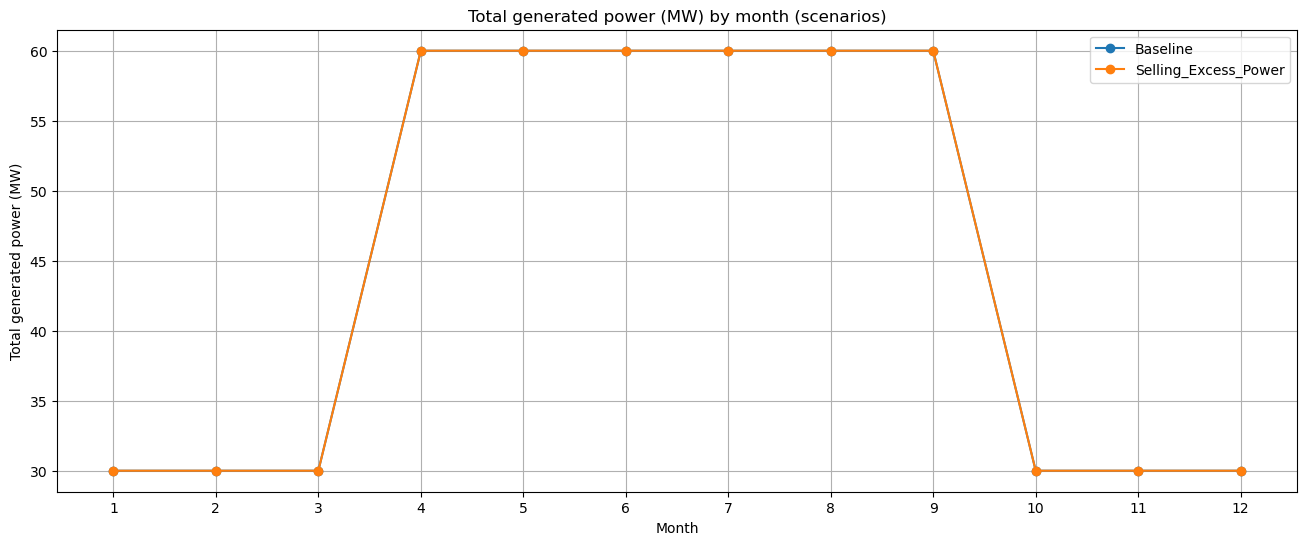

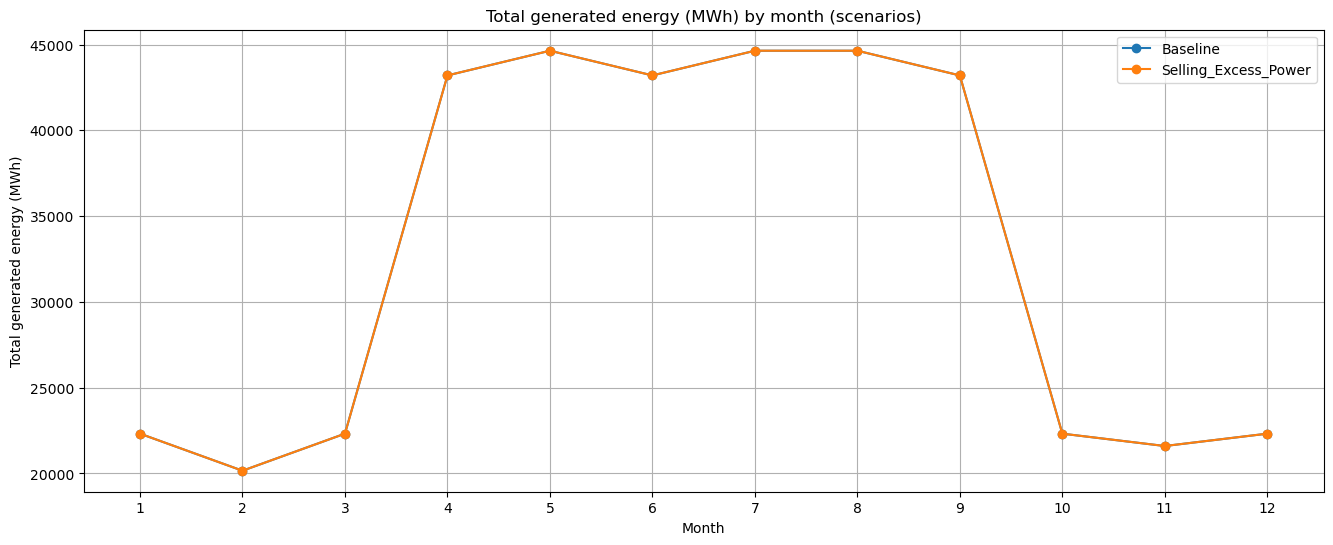

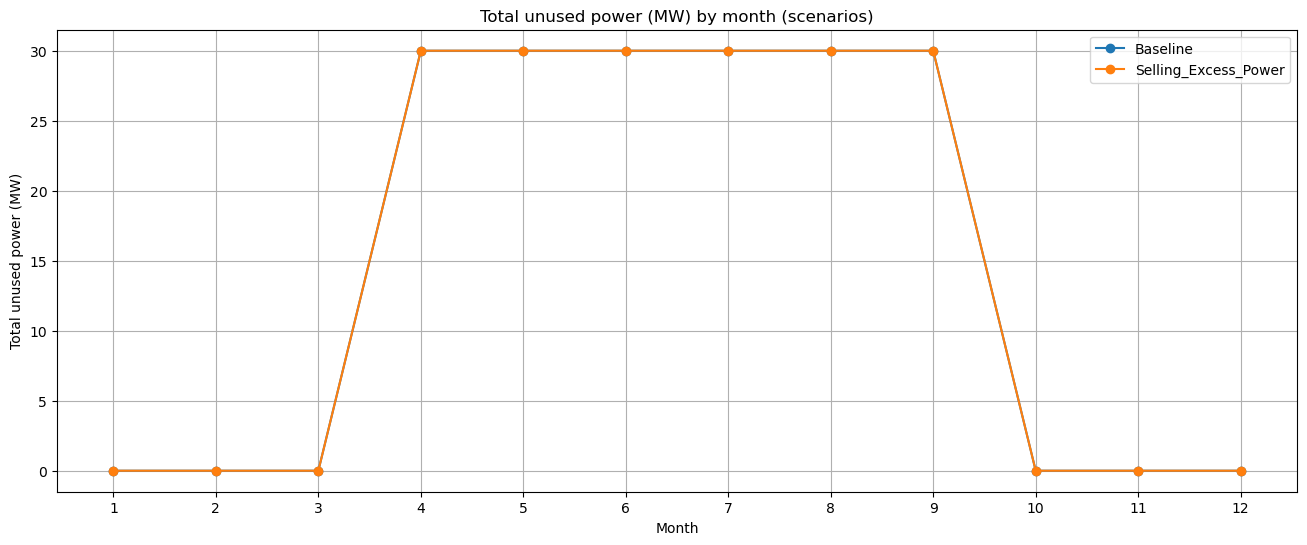

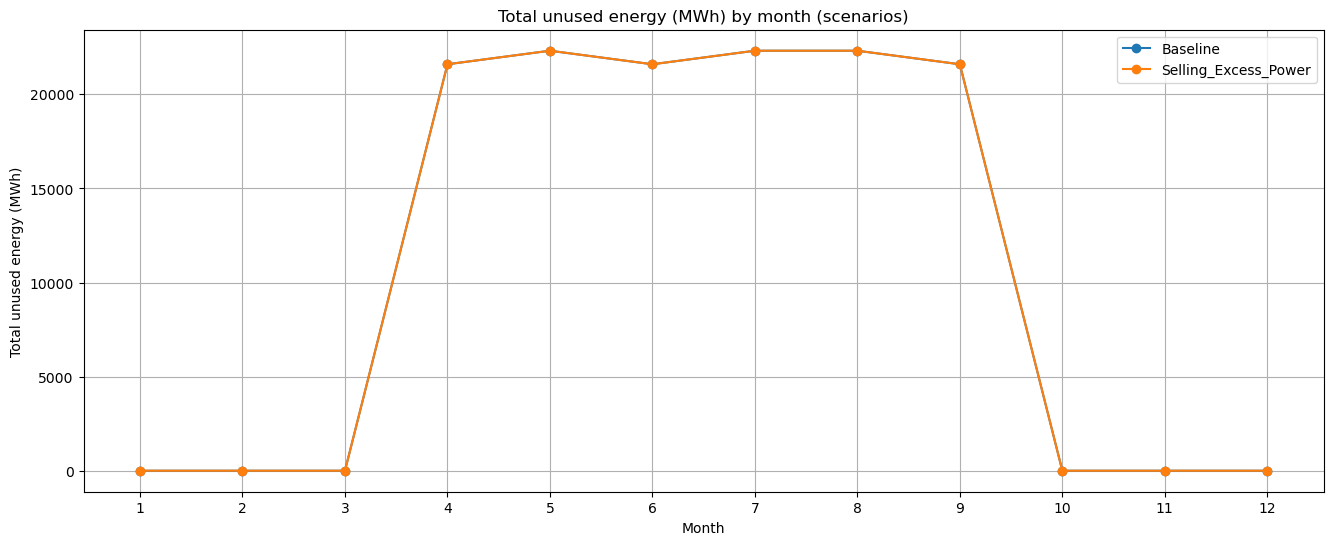

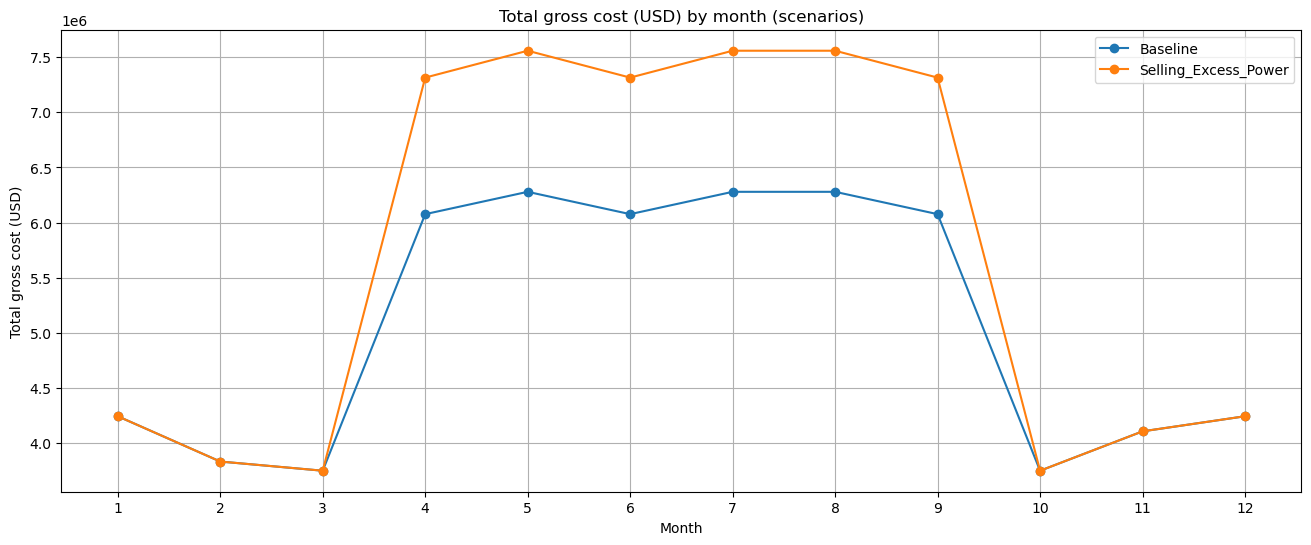

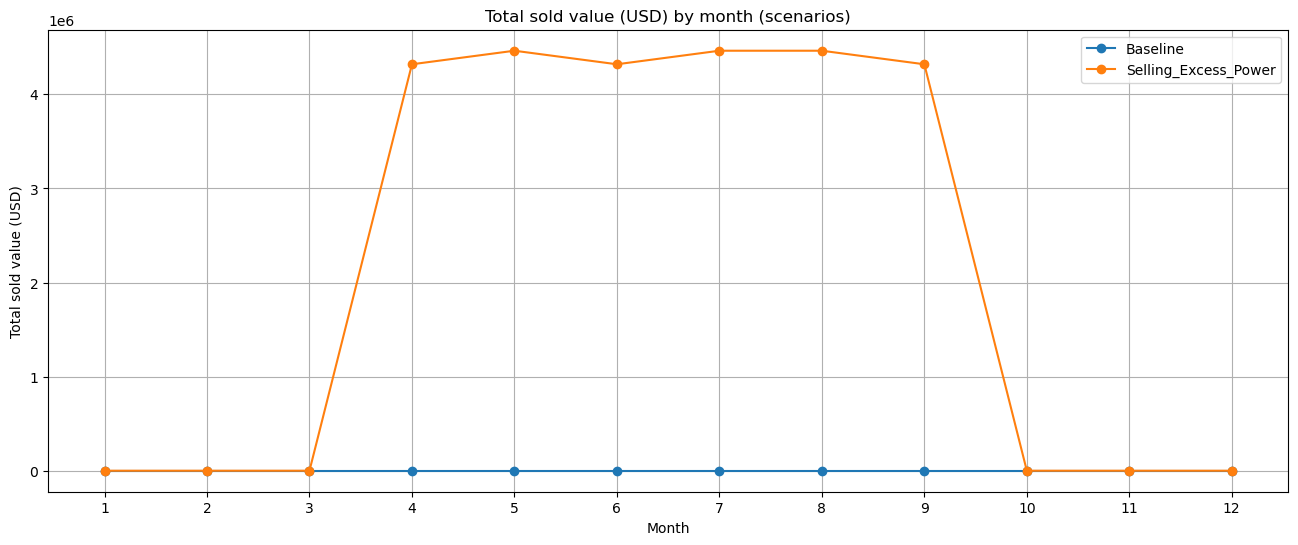

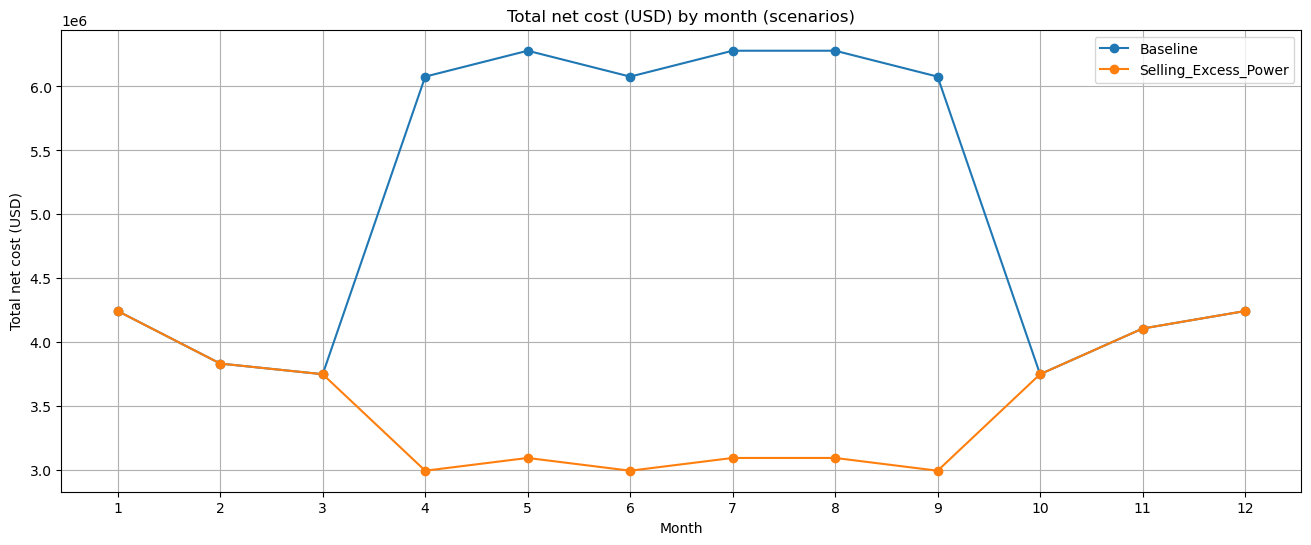

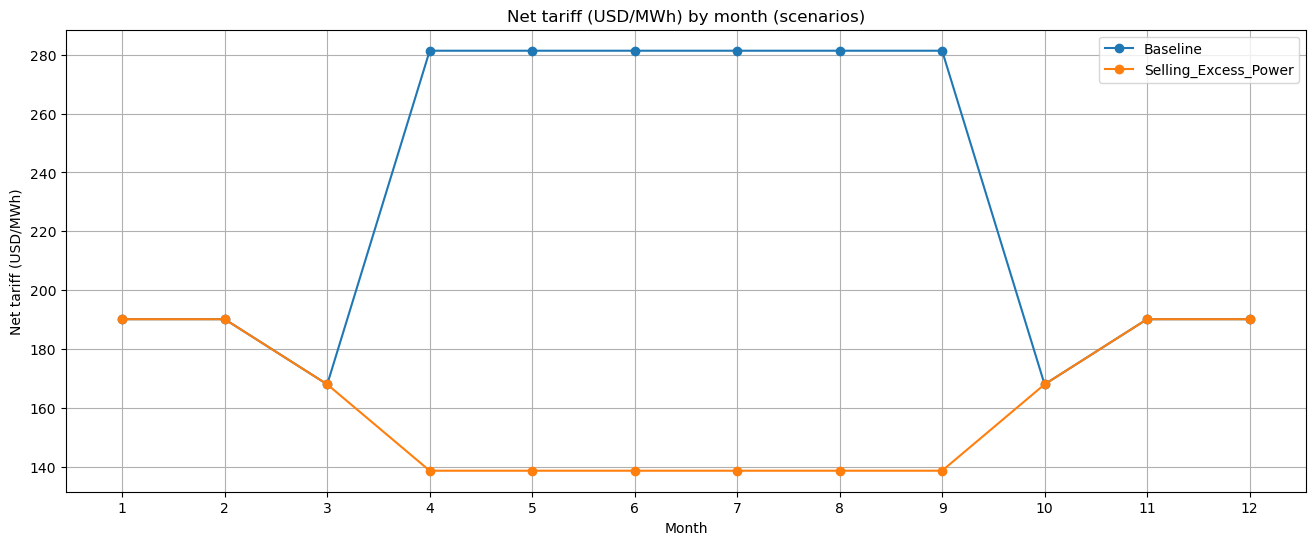

In [41]:
# Cell 16 — Scenario comparison (by month)
# Requires: scenario_results_active (preferred) or scenario_results

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sr = scenario_results_active if "scenario_results_active" in globals() else scenario_results

if "sr" not in locals() or not isinstance(sr, dict) or len(sr) == 0:
    raise RuntimeError("No scenario results found. Run Cell 6 first.")

# Keep scenario order consistent with Cell 4, if possible
if "scenarios" in globals() and isinstance(scenarios, list) and len(scenarios) > 0:
    scenario_names = [s["name"] for s in scenarios if s.get("name") in sr]
else:
    scenario_names = sorted(sr.keys())

# Union of months across scenarios
months_all = sorted({int(m) for name in scenario_names for m in sr[name]["df"]["month"].unique()})


def scenario_monthly_metrics(df_sc: pd.DataFrame) -> pd.DataFrame:
    out = (
        df_sc.groupby("month", as_index=False)
        .agg(
            TotalGeneratedPower_MW=("Generated_MW", "sum"),
            TotalGeneratedEnergy_MWh=("Generated_MWh", "sum"),
            TotalGrossCost_USD=("GrossCost_USD", "sum"),
            TotalSoldValue_USD=("SoldValue_USD", "sum"),
            TotalNetCost_USD=("NetCost_USD", "sum"),
            UsedPower_MW=("Power_MW", "sum"),
            UsedEnergy_MWh=("Energy_MWh", "sum"),
        )
        .set_index("month")
        .sort_index()
    )
    out["TotalUnusedPower_MW"] = (out["TotalGeneratedPower_MW"] - out["UsedPower_MW"]).clip(lower=0)
    out["TotalUnusedEnergy_MWh"] = (out["TotalGeneratedEnergy_MWh"] - out["UsedEnergy_MWh"]).clip(lower=0)
    out["NetTariff_USD_per_MWh"] = (
        out["TotalNetCost_USD"] / out["UsedEnergy_MWh"].replace(0, np.nan)
    ).replace([np.inf, -np.inf], np.nan)
    return out


monthly_by_scenario = {
    name: scenario_monthly_metrics(sr[name]["df"]).reindex(months_all)
    for name in scenario_names
}


def plot_monthly(metric: str, ylabel: str, title: str):
    plt.figure(figsize=(16, 6))
    for name in scenario_names:
        s = monthly_by_scenario[name][metric]
        plt.plot(months_all, s.values, marker="o", label=name)

    plt.xticks(months_all)
    plt.xlabel("Month")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


plot_monthly(
    "TotalGeneratedPower_MW",
    ylabel="Total generated power (MW)",
    title="Total generated power (MW) by month (scenarios)",
)
plot_monthly(
    "TotalGeneratedEnergy_MWh",
    ylabel="Total generated energy (MWh)",
    title="Total generated energy (MWh) by month (scenarios)",
)
plot_monthly(
    "TotalUnusedPower_MW",
    ylabel="Total unused power (MW)",
    title="Total unused power (MW) by month (scenarios)",
)
plot_monthly(
    "TotalUnusedEnergy_MWh",
    ylabel="Total unused energy (MWh)",
    title="Total unused energy (MWh) by month (scenarios)",
)
plot_monthly(
    "TotalGrossCost_USD",
    ylabel="Total gross cost (USD)",
    title="Total gross cost (USD) by month (scenarios)",
)
plot_monthly(
    "TotalSoldValue_USD",
    ylabel="Total sold value (USD)",
    title="Total sold value (USD) by month (scenarios)",
)
plot_monthly(
    "TotalNetCost_USD",
    ylabel="Total net cost (USD)",
    title="Total net cost (USD) by month (scenarios)",
)
plot_monthly(
    "NetTariff_USD_per_MWh",
    ylabel="Net tariff (USD/MWh)",
    title="Net tariff (USD/MWh) by month (scenarios)",
)


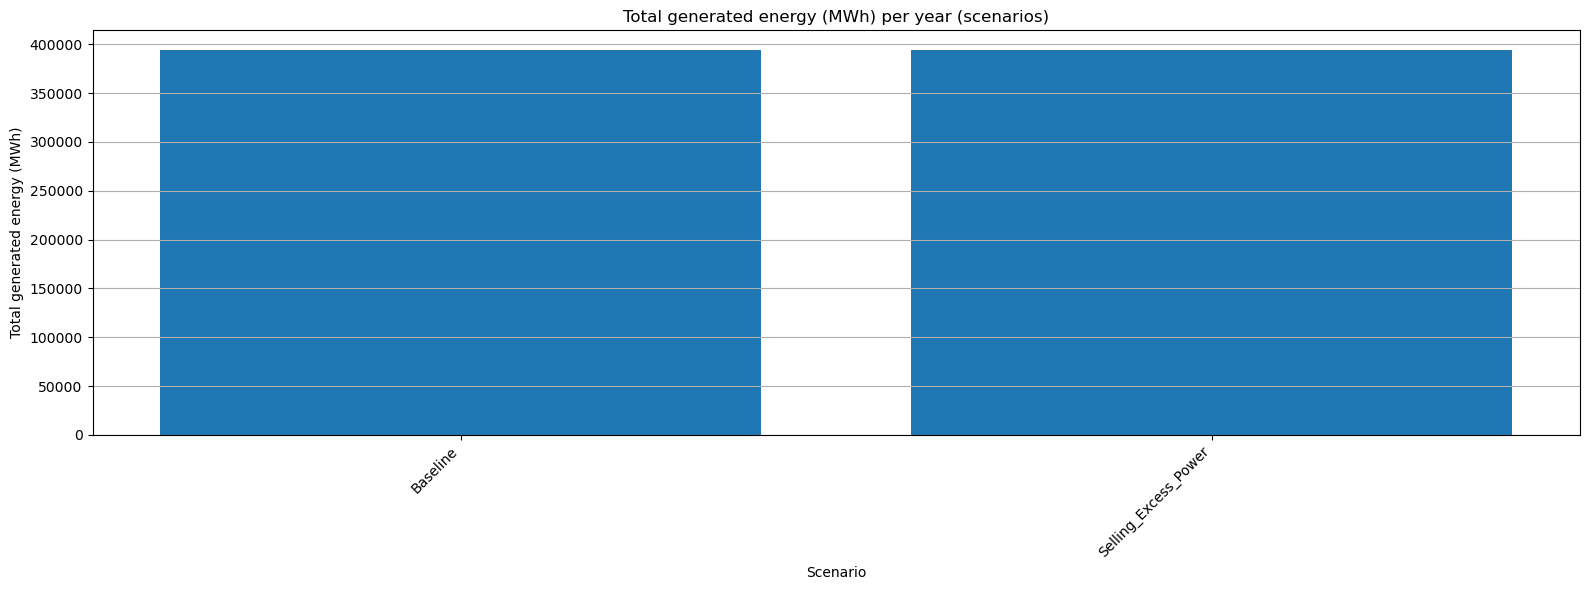

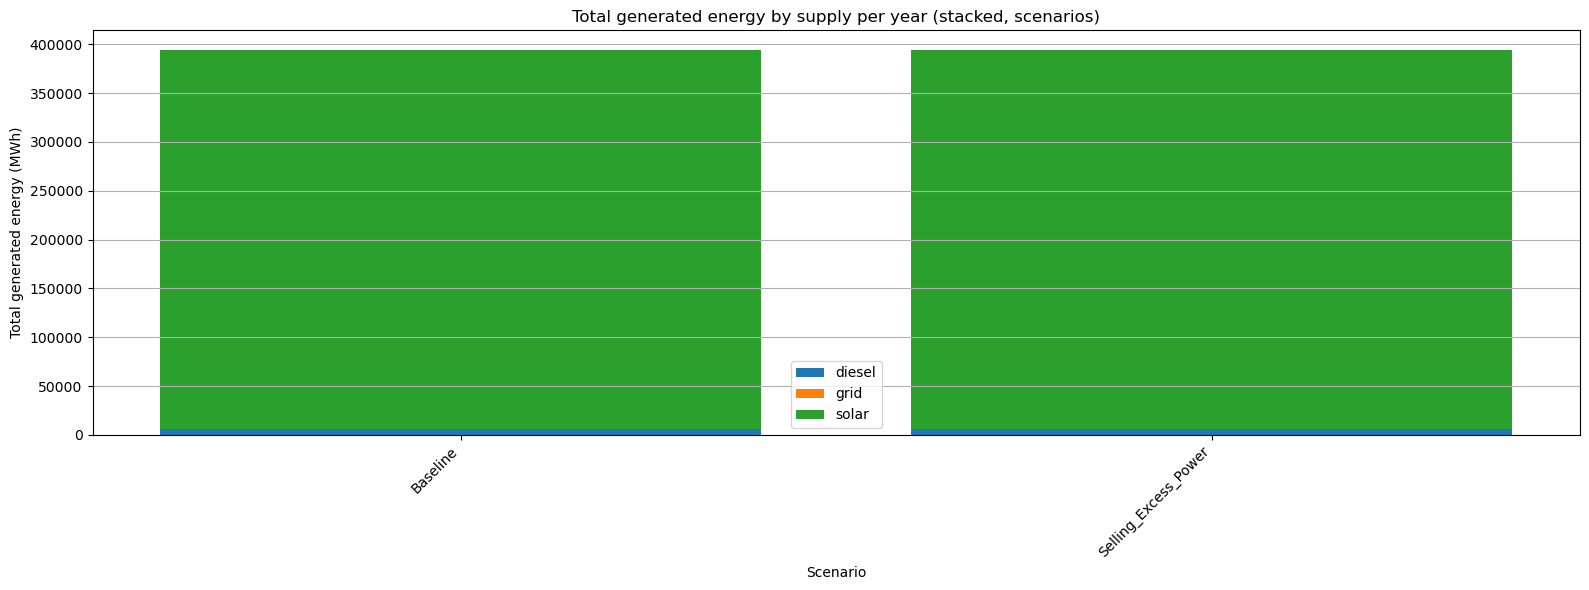

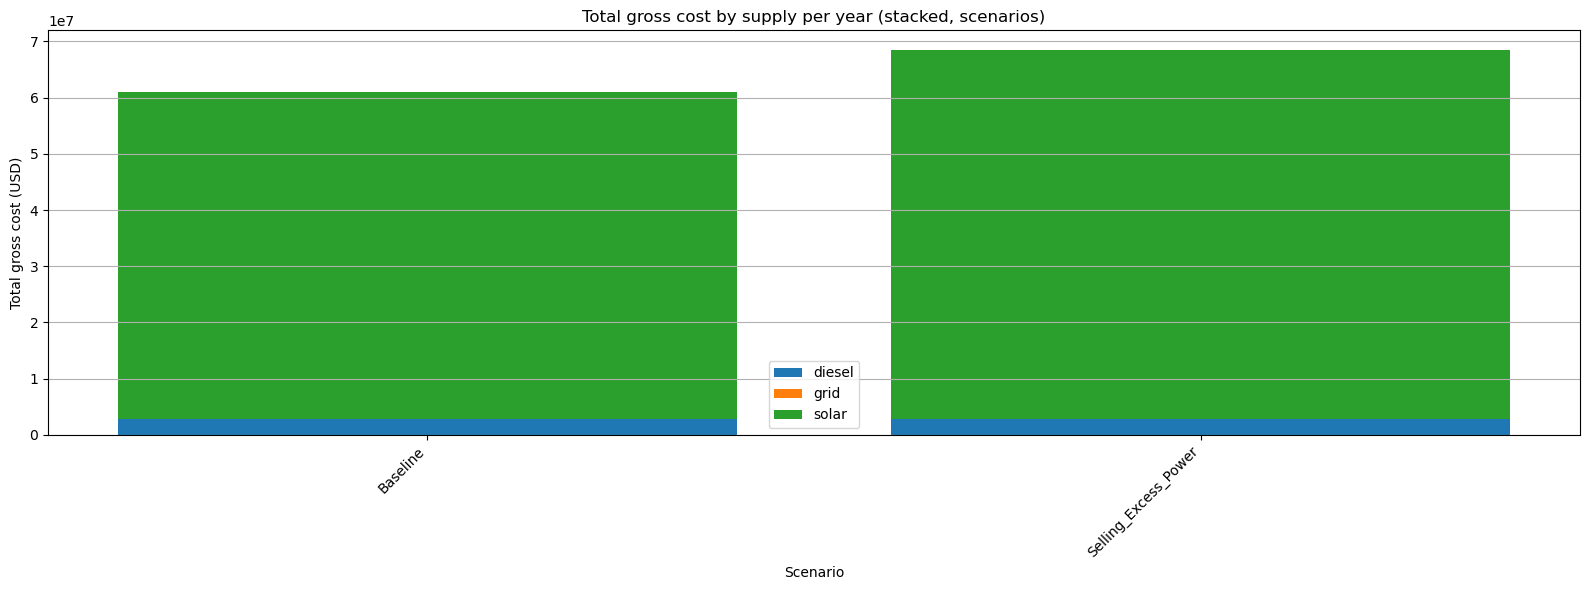

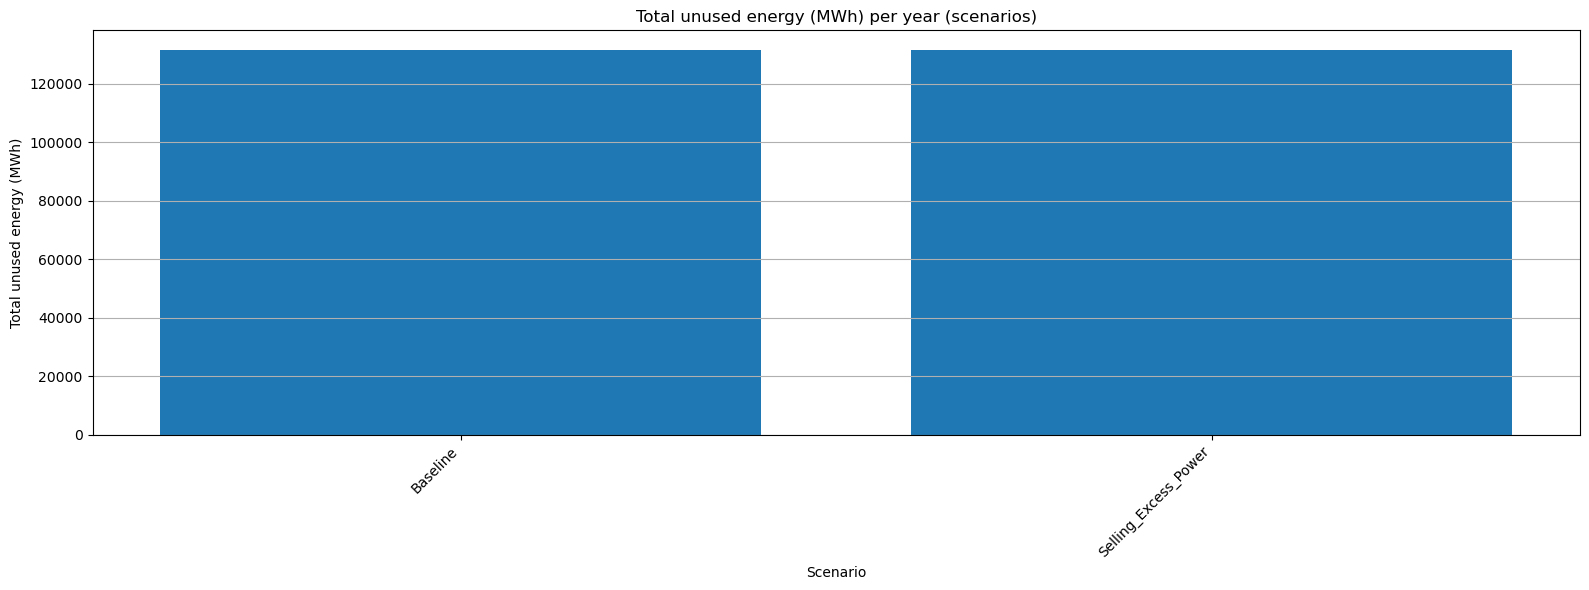

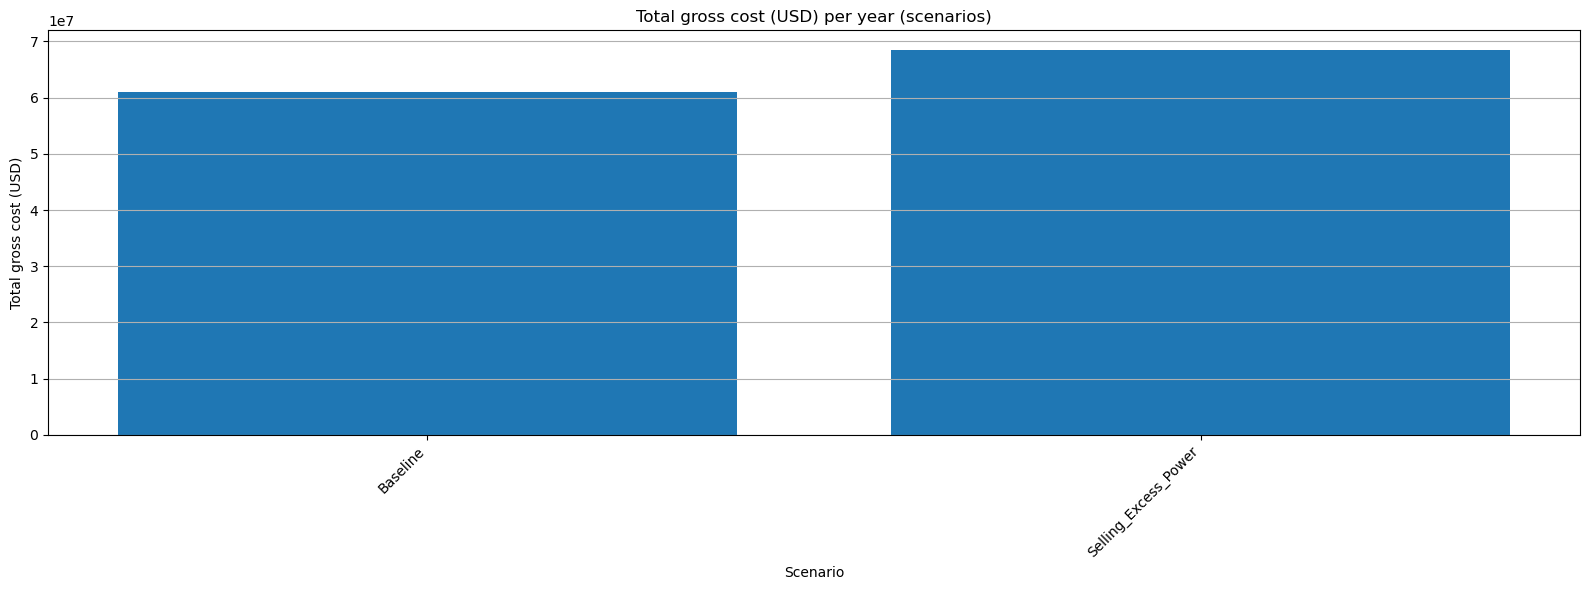

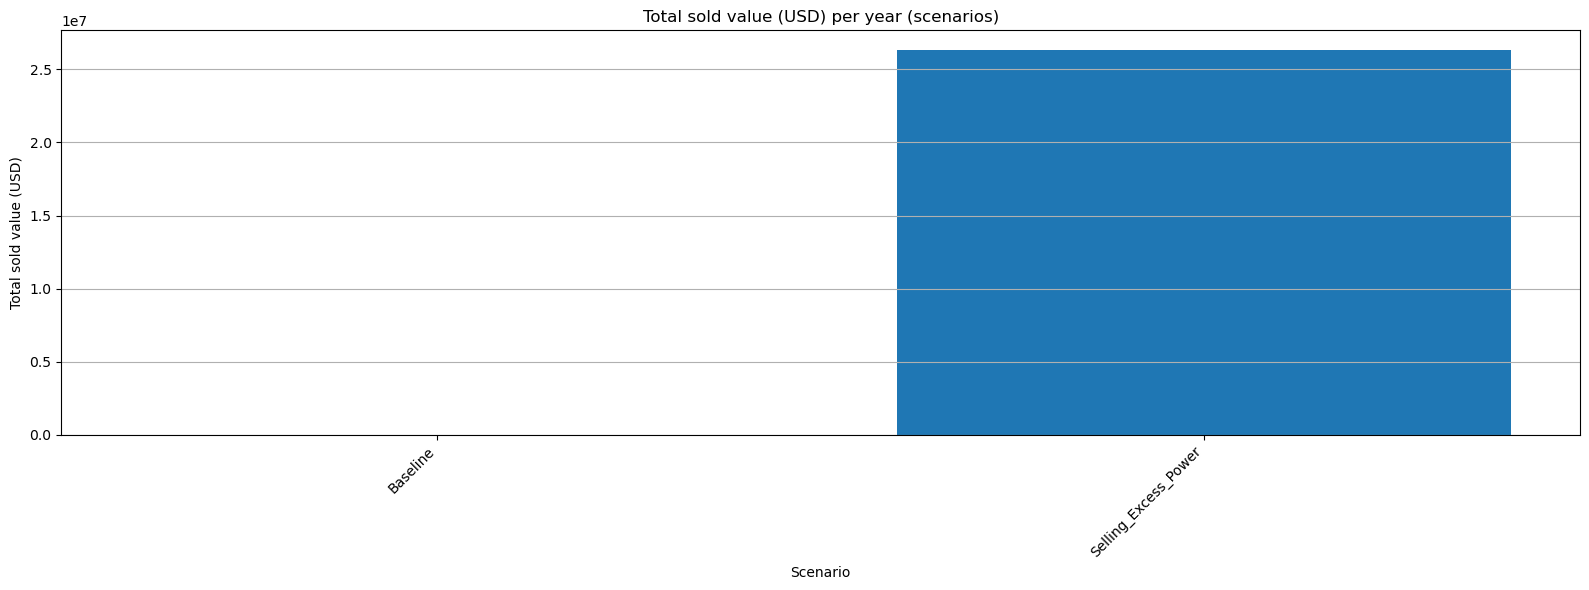

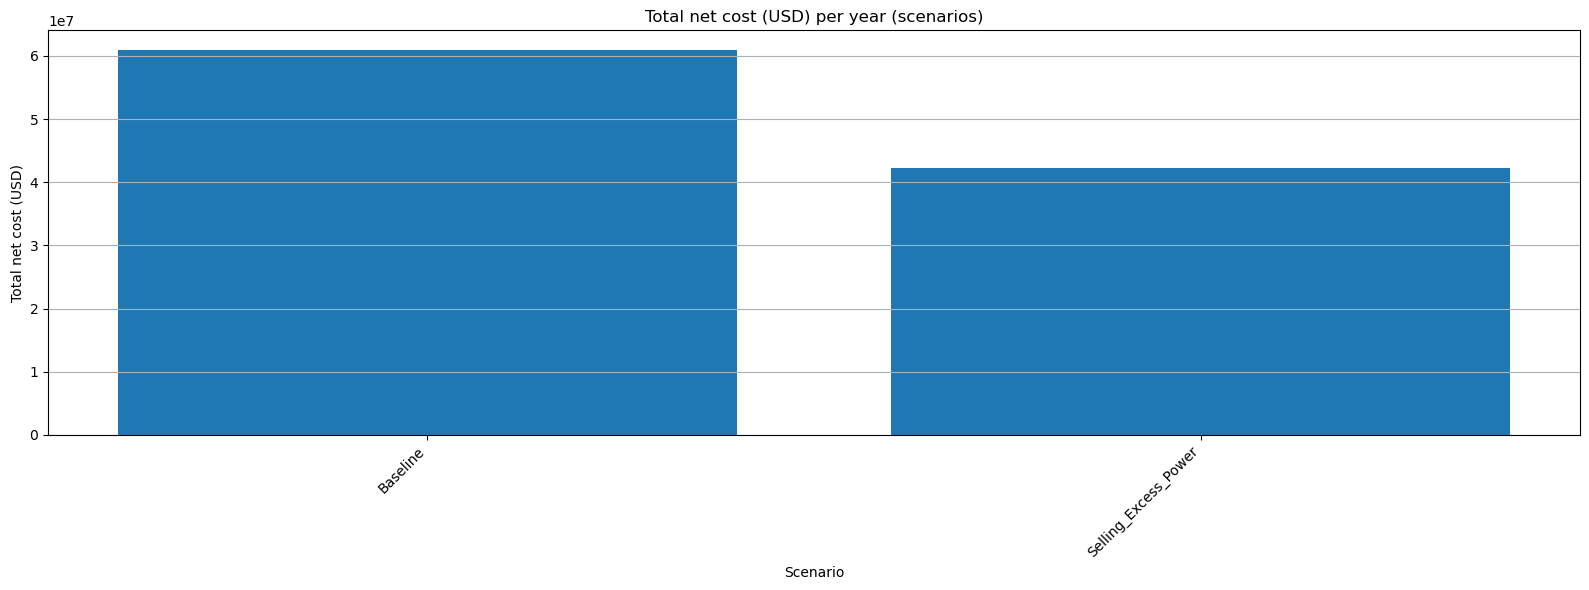

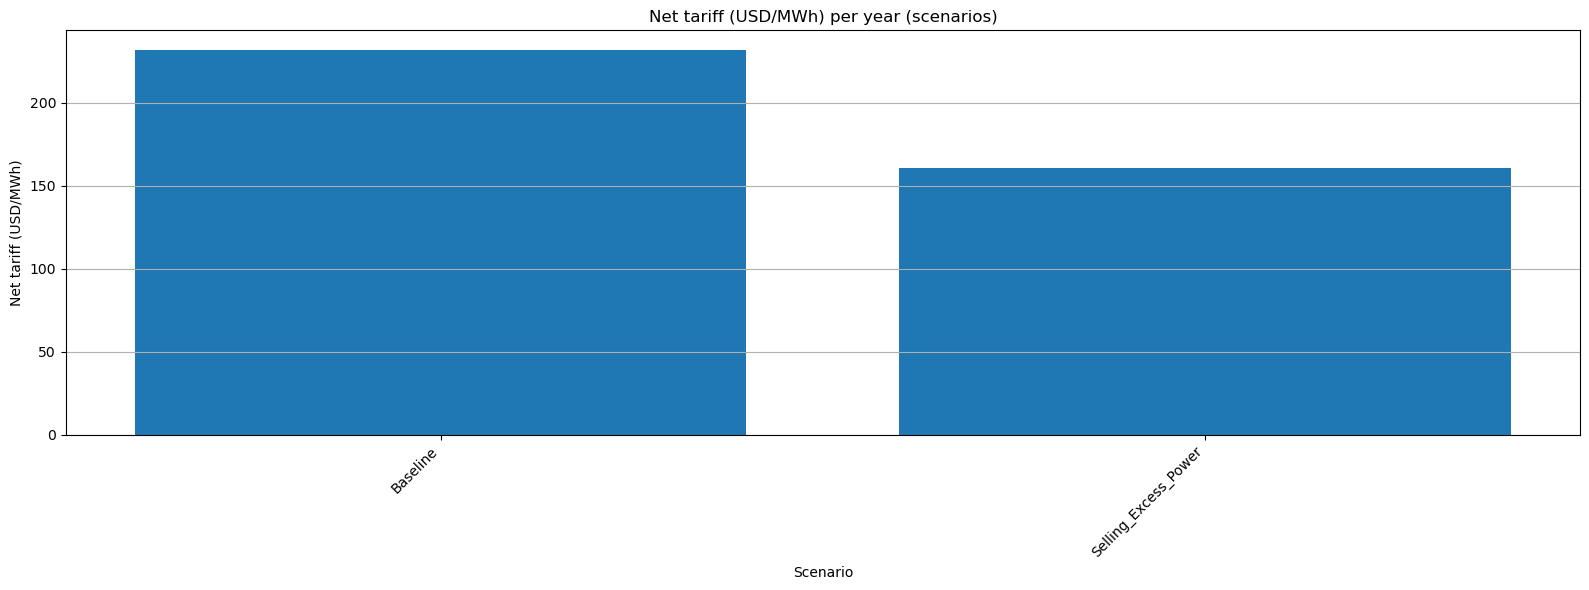

Yearly metrics table:


,AvgTotalGeneratedPower_MW,TotalGeneratedEnergy_MWh,AvgTotalUnusedPower_MW,TotalUnusedEnergy_MWh,TotalGrossCost_USD,TotalSoldValue_USD,TotalNetCost_USD,NetTariff_USD_per_MWh
Baseline,45.0,394560.0,15.0,131760.0,60995520.0,0.0,60995520.0,232.0986
Selling_Excess_Power,45.0,394560.0,15.0,131760.0,68549760.0,26352000.0,42197760.0,160.5699


In [42]:
# Cell 17 — Scenario comparison (per year)
# Requires: scenario_results_active (preferred) or scenario_results

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sr = scenario_results_active if "scenario_results_active" in globals() else scenario_results

if "sr" not in locals() or not isinstance(sr, dict) or len(sr) == 0:
    raise RuntimeError("No scenario results found. Run Cell 6 first.")

# Keep scenario order consistent with Cell 4, if possible
if "scenarios" in globals() and isinstance(scenarios, list) and len(scenarios) > 0:
    scenario_names = [s["name"] for s in scenarios if s.get("name") in sr]
else:
    scenario_names = sorted(sr.keys())


def scenario_yearly_metrics(df_sc: pd.DataFrame) -> dict:
    used_energy_mwh = float(df_sc["Energy_MWh"].sum())
    total_generated_energy_mwh = float(df_sc["Generated_MWh"].sum())

    # MW is a rate, not additive; use the mean of monthly totals as the yearly representative value.
    monthly_generated_mw = df_sc.groupby("month")["Generated_MW"].sum()
    monthly_used_mw = df_sc.groupby("month")["Power_MW"].sum()
    monthly_unused_mw = (monthly_generated_mw - monthly_used_mw).clip(lower=0)

    return {
        "AvgTotalGeneratedPower_MW": float(monthly_generated_mw.mean()),
        "TotalGeneratedEnergy_MWh": total_generated_energy_mwh,
        "AvgTotalUnusedPower_MW": float(monthly_unused_mw.mean()),
        "TotalUnusedEnergy_MWh": float(max(0.0, total_generated_energy_mwh - used_energy_mwh)),
        "TotalGrossCost_USD": float(df_sc["GrossCost_USD"].sum()),
        "TotalSoldValue_USD": float(df_sc["SoldValue_USD"].sum()),
        "TotalNetCost_USD": float(df_sc["NetCost_USD"].sum()),
        "NetTariff_USD_per_MWh": float(df_sc["NetCost_USD"].sum() / used_energy_mwh) if used_energy_mwh > 0 else np.nan,
    }


yearly = pd.DataFrame({name: scenario_yearly_metrics(sr[name]["df"]) for name in scenario_names}).T


def plot_yearly_bar(metric: str, ylabel: str, title: str):
    vals = yearly[metric].reindex(scenario_names)
    x = np.arange(len(scenario_names))

    plt.figure(figsize=(16, 6))
    plt.bar(x, vals.values)
    plt.xticks(x, scenario_names, rotation=45, ha="right")
    plt.xlabel("Scenario")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()


plot_yearly_bar(
    "TotalGeneratedEnergy_MWh",
    ylabel="Total generated energy (MWh)",
    title="Total generated energy (MWh) per year (scenarios)",
)

# Stacked breakdown: total generated energy by supply per year (scenarios)
supplies_all = sorted({str(s) for name in scenario_names for s in sr[name]["df"]["supply"].unique()})

gen_energy_by_supply_yearly = (
    pd.DataFrame({name: sr[name]["df"].groupby("supply")["Generated_MWh"].sum() for name in scenario_names})
    .T
    .reindex(index=scenario_names)
)

# Ensure all supplies exist as columns (missing -> 0)
for supply in supplies_all:
    if supply not in gen_energy_by_supply_yearly.columns:
        gen_energy_by_supply_yearly[supply] = 0.0

gen_energy_by_supply_yearly = gen_energy_by_supply_yearly.reindex(columns=supplies_all).fillna(0.0)

x = np.arange(len(scenario_names))
bottom = np.zeros(len(scenario_names), dtype=float)

plt.figure(figsize=(16, 6))
for supply in supplies_all:
    vals = gen_energy_by_supply_yearly[supply].values
    plt.bar(x, vals, bottom=bottom, label=supply)
    bottom = bottom + vals

plt.xticks(x, scenario_names, rotation=45, ha="right")
plt.xlabel("Scenario")
plt.ylabel("Total generated energy (MWh)")
plt.title("Total generated energy by supply per year (stacked, scenarios)")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

# Stacked breakdown: total gross cost by supply per year (scenarios)
gross_cost_by_supply_yearly = (
    pd.DataFrame({name: sr[name]["df"].groupby("supply")["GrossCost_USD"].sum() for name in scenario_names})
    .T
    .reindex(index=scenario_names)
)

for supply in supplies_all:
    if supply not in gross_cost_by_supply_yearly.columns:
        gross_cost_by_supply_yearly[supply] = 0.0

gross_cost_by_supply_yearly = gross_cost_by_supply_yearly.reindex(columns=supplies_all).fillna(0.0)

x = np.arange(len(scenario_names))
bottom = np.zeros(len(scenario_names), dtype=float)

plt.figure(figsize=(16, 6))
for supply in supplies_all:
    vals = gross_cost_by_supply_yearly[supply].values
    plt.bar(x, vals, bottom=bottom, label=supply)
    bottom = bottom + vals

plt.xticks(x, scenario_names, rotation=45, ha="right")
plt.xlabel("Scenario")
plt.ylabel("Total gross cost (USD)")
plt.title("Total gross cost by supply per year (stacked, scenarios)")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

plot_yearly_bar(
    "TotalUnusedEnergy_MWh",
    ylabel="Total unused energy (MWh)",
    title="Total unused energy (MWh) per year (scenarios)",
)
plot_yearly_bar(
    "TotalGrossCost_USD",
    ylabel="Total gross cost (USD)",
    title="Total gross cost (USD) per year (scenarios)",
)
plot_yearly_bar(
    "TotalSoldValue_USD",
    ylabel="Total sold value (USD)",
    title="Total sold value (USD) per year (scenarios)",
)
plot_yearly_bar(
    "TotalNetCost_USD",
    ylabel="Total net cost (USD)",
    title="Total net cost (USD) per year (scenarios)",
)
plot_yearly_bar(
    "NetTariff_USD_per_MWh",
    ylabel="Net tariff (USD/MWh)",
    title="Net tariff (USD/MWh) per year (scenarios)",
)

print("Yearly metrics table:")
display(yearly.round(4))
